In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_coords_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3944610, 831)
(3944610, 8)
validation
(464344, 831)
(464344, 8)
test
(574820, 831)
(574820, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 831)]             0         


 dense (Dense)               (None, 1024)              851968    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1542024 (5.88 MB)


Trainable params: 1542024 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/395 [..............................] - ETA: 8:42 - loss: 2.3164 - STD: 0.1044 - MAE: 0.2181

  5/395 [..............................] - ETA: 5s - loss: 2.1305 - STD: 0.0552 - MAE: 0.2169  

  9/395 [..............................] - ETA: 5s - loss: 2.1132 - STD: 0.0529 - MAE: 0.2166

 13/395 [..............................] - ETA: 5s - loss: 2.0965 - STD: 0.0493 - MAE: 0.2165

 17/395 [>.............................] - ETA: 5s - loss: 2.0852 - STD: 0.0441 - MAE: 0.2166

 21/395 [>.............................] - ETA: 5s - loss: 2.0786 - STD: 0.0426 - MAE: 0.2165

 25/395 [>.............................] - ETA: 5s - loss: 2.0710 - STD: 0.0410 - MAE: 0.2164

 29/395 [=>............................] - ETA: 5s - loss: 2.0623 - STD: 0.0400 - MAE: 0.2163

 33/395 [=>............................] - ETA: 5s - loss: 2.0523 - STD: 0.0402 - MAE: 0.2159

 37/395 [=>............................] - ETA: 5s - loss: 2.0399 - STD: 0.0417 - MAE: 0.2154

 41/395 [==>...........................] - ETA: 5s - loss: 2.0262 - STD: 0.0436 - MAE: 0.2148

 45/395 [==>...........................] - ETA: 5s - loss: 2.0126 - STD: 0.0461 - MAE: 0.2141

 49/395 [==>...........................] - ETA: 5s - loss: 1.9994 - STD: 0.0486 - MAE: 0.2134

 53/395 [===>..........................] - ETA: 5s - loss: 1.9871 - STD: 0.0508 - MAE: 0.2128

 57/395 [===>..........................] - ETA: 5s - loss: 1.9753 - STD: 0.0528 - MAE: 0.2122

 61/395 [===>..........................] - ETA: 5s - loss: 1.9637 - STD: 0.0548 - MAE: 0.2115

 65/395 [===>..........................] - ETA: 5s - loss: 1.9519 - STD: 0.0566 - MAE: 0.2109

 69/395 [====>.........................] - ETA: 5s - loss: 1.9396 - STD: 0.0584 - MAE: 0.2103

 73/395 [====>.........................] - ETA: 4s - loss: 1.9260 - STD: 0.0602 - MAE: 0.2096

 77/395 [====>.........................] - ETA: 4s - loss: 1.9111 - STD: 0.0621 - MAE: 0.2089

 81/395 [=====>........................] - ETA: 4s - loss: 1.8949 - STD: 0.0642 - MAE: 0.2080

 85/395 [=====>........................] - ETA: 4s - loss: 1.8781 - STD: 0.0666 - MAE: 0.2070

 89/395 [=====>........................] - ETA: 4s - loss: 1.8612 - STD: 0.0689 - MAE: 0.2060

 93/395 [======>.......................] - ETA: 4s - loss: 1.8440 - STD: 0.0714 - MAE: 0.2050

 97/395 [======>.......................] - ETA: 4s - loss: 1.8273 - STD: 0.0739 - MAE: 0.2039

101/395 [======>.......................] - ETA: 4s - loss: 1.8109 - STD: 0.0764 - MAE: 0.2028

105/395 [======>.......................] - ETA: 4s - loss: 1.7947 - STD: 0.0788 - MAE: 0.2018

109/395 [=======>......................] - ETA: 4s - loss: 1.7794 - STD: 0.0813 - MAE: 0.2007

113/395 [=======>......................] - ETA: 4s - loss: 1.7644 - STD: 0.0836 - MAE: 0.1997

117/395 [=======>......................] - ETA: 4s - loss: 1.7501 - STD: 0.0860 - MAE: 0.1986

121/395 [========>.....................] - ETA: 4s - loss: 1.7367 - STD: 0.0882 - MAE: 0.1976

125/395 [========>.....................] - ETA: 4s - loss: 1.7240 - STD: 0.0903 - MAE: 0.1967

129/395 [========>.....................] - ETA: 4s - loss: 1.7115 - STD: 0.0924 - MAE: 0.1958

133/395 [=========>....................] - ETA: 4s - loss: 1.6996 - STD: 0.0944 - MAE: 0.1948

137/395 [=========>....................] - ETA: 4s - loss: 1.6883 - STD: 0.0963 - MAE: 0.1940

141/395 [=========>....................] - ETA: 3s - loss: 1.6776 - STD: 0.0981 - MAE: 0.1932

145/395 [==========>...................] - ETA: 3s - loss: 1.6672 - STD: 0.0999 - MAE: 0.1924

149/395 [==========>...................] - ETA: 3s - loss: 1.6576 - STD: 0.1015 - MAE: 0.1916

153/395 [==========>...................] - ETA: 3s - loss: 1.6479 - STD: 0.1031 - MAE: 0.1909

157/395 [==========>...................] - ETA: 3s - loss: 1.6386 - STD: 0.1047 - MAE: 0.1901

161/395 [===========>..................] - ETA: 3s - loss: 1.6297 - STD: 0.1062 - MAE: 0.1894

165/395 [===========>..................] - ETA: 3s - loss: 1.6209 - STD: 0.1076 - MAE: 0.1888

169/395 [===========>..................] - ETA: 3s - loss: 1.6126 - STD: 0.1090 - MAE: 0.1881

173/395 [============>.................] - ETA: 3s - loss: 1.6044 - STD: 0.1104 - MAE: 0.1874

177/395 [============>.................] - ETA: 3s - loss: 1.5967 - STD: 0.1118 - MAE: 0.1868

181/395 [============>.................] - ETA: 3s - loss: 1.5892 - STD: 0.1131 - MAE: 0.1862

185/395 [=============>................] - ETA: 3s - loss: 1.5819 - STD: 0.1143 - MAE: 0.1856

189/395 [=============>................] - ETA: 3s - loss: 1.5748 - STD: 0.1155 - MAE: 0.1850

193/395 [=============>................] - ETA: 3s - loss: 1.5678 - STD: 0.1167 - MAE: 0.1845

197/395 [=============>................] - ETA: 3s - loss: 1.5612 - STD: 0.1178 - MAE: 0.1839

201/395 [==============>...............] - ETA: 3s - loss: 1.5546 - STD: 0.1189 - MAE: 0.1834

205/395 [==============>...............] - ETA: 2s - loss: 1.5482 - STD: 0.1200 - MAE: 0.1828

208/395 [==============>...............] - ETA: 2s - loss: 1.5436 - STD: 0.1208 - MAE: 0.1824

211/395 [===============>..............] - ETA: 3s - loss: 1.5399 - STD: 0.1216 - MAE: 0.1821

215/395 [===============>..............] - ETA: 3s - loss: 1.5337 - STD: 0.1226 - MAE: 0.1816

219/395 [===============>..............] - ETA: 3s - loss: 1.5278 - STD: 0.1235 - MAE: 0.1811

223/395 [===============>..............] - ETA: 3s - loss: 1.5221 - STD: 0.1245 - MAE: 0.1806

227/395 [================>.............] - ETA: 3s - loss: 1.5166 - STD: 0.1254 - MAE: 0.1801

231/395 [================>.............] - ETA: 3s - loss: 1.5112 - STD: 0.1263 - MAE: 0.1797

235/395 [================>.............] - ETA: 2s - loss: 1.5059 - STD: 0.1272 - MAE: 0.1792

239/395 [=================>............] - ETA: 2s - loss: 1.5007 - STD: 0.1281 - MAE: 0.1788

243/395 [=================>............] - ETA: 2s - loss: 1.4957 - STD: 0.1289 - MAE: 0.1784

247/395 [=================>............] - ETA: 2s - loss: 1.4908 - STD: 0.1298 - MAE: 0.1779

251/395 [==================>...........] - ETA: 2s - loss: 1.4861 - STD: 0.1306 - MAE: 0.1775

255/395 [==================>...........] - ETA: 2s - loss: 1.4814 - STD: 0.1313 - MAE: 0.1771

259/395 [==================>...........] - ETA: 2s - loss: 1.4769 - STD: 0.1321 - MAE: 0.1768

263/395 [==================>...........] - ETA: 2s - loss: 1.4723 - STD: 0.1329 - MAE: 0.1764

267/395 [===================>..........] - ETA: 2s - loss: 1.4678 - STD: 0.1336 - MAE: 0.1760

271/395 [===================>..........] - ETA: 2s - loss: 1.4634 - STD: 0.1343 - MAE: 0.1756

275/395 [===================>..........] - ETA: 2s - loss: 1.4593 - STD: 0.1350 - MAE: 0.1752

279/395 [====================>.........] - ETA: 2s - loss: 1.4552 - STD: 0.1357 - MAE: 0.1749

283/395 [====================>.........] - ETA: 2s - loss: 1.4512 - STD: 0.1364 - MAE: 0.1745

287/395 [====================>.........] - ETA: 1s - loss: 1.4471 - STD: 0.1370 - MAE: 0.1742

291/395 [=====================>........] - ETA: 1s - loss: 1.4431 - STD: 0.1377 - MAE: 0.1738

295/395 [=====================>........] - ETA: 1s - loss: 1.4391 - STD: 0.1383 - MAE: 0.1735

299/395 [=====================>........] - ETA: 1s - loss: 1.4352 - STD: 0.1390 - MAE: 0.1732

303/395 [======================>.......] - ETA: 1s - loss: 1.4314 - STD: 0.1396 - MAE: 0.1728

307/395 [======================>.......] - ETA: 1s - loss: 1.4275 - STD: 0.1402 - MAE: 0.1725

311/395 [======================>.......] - ETA: 1s - loss: 1.4237 - STD: 0.1408 - MAE: 0.1722

315/395 [======================>.......] - ETA: 1s - loss: 1.4202 - STD: 0.1414 - MAE: 0.1719

319/395 [=======================>......] - ETA: 1s - loss: 1.4172 - STD: 0.1420 - MAE: 0.1716

323/395 [=======================>......] - ETA: 1s - loss: 1.4139 - STD: 0.1425 - MAE: 0.1713

327/395 [=======================>......] - ETA: 1s - loss: 1.4107 - STD: 0.1431 - MAE: 0.1710

331/395 [========================>.....] - ETA: 1s - loss: 1.4075 - STD: 0.1436 - MAE: 0.1707

335/395 [========================>.....] - ETA: 1s - loss: 1.4042 - STD: 0.1442 - MAE: 0.1704

339/395 [========================>.....] - ETA: 0s - loss: 1.4010 - STD: 0.1447 - MAE: 0.1701

343/395 [=========================>....] - ETA: 0s - loss: 1.3977 - STD: 0.1452 - MAE: 0.1699

347/395 [=========================>....] - ETA: 0s - loss: 1.3945 - STD: 0.1457 - MAE: 0.1696

351/395 [=========================>....] - ETA: 0s - loss: 1.3914 - STD: 0.1462 - MAE: 0.1693

355/395 [=========================>....] - ETA: 0s - loss: 1.3882 - STD: 0.1467 - MAE: 0.1690

359/395 [==========================>...] - ETA: 0s - loss: 1.3853 - STD: 0.1472 - MAE: 0.1688

363/395 [==========================>...] - ETA: 0s - loss: 1.3822 - STD: 0.1476 - MAE: 0.1685

367/395 [==========================>...] - ETA: 0s - loss: 1.3793 - STD: 0.1481 - MAE: 0.1682

371/395 [===========================>..] - ETA: 0s - loss: 1.3764 - STD: 0.1486 - MAE: 0.1680

375/395 [===========================>..] - ETA: 0s - loss: 1.3735 - STD: 0.1490 - MAE: 0.1677

379/395 [===========================>..] - ETA: 0s - loss: 1.3709 - STD: 0.1495 - MAE: 0.1675

383/395 [============================>.] - ETA: 0s - loss: 1.3681 - STD: 0.1499 - MAE: 0.1672

387/395 [============================>.] - ETA: 0s - loss: 1.3655 - STD: 0.1504 - MAE: 0.1670

391/395 [============================>.] - ETA: 0s - loss: 1.3628 - STD: 0.1508 - MAE: 0.1667

395/395 [==============================] - ETA: 0s - loss: 1.3601 - STD: 0.1512 - MAE: 0.1665

395/395 [==============================] - 9s 20ms/step - loss: 1.3601 - STD: 0.1512 - MAE: 0.1665 - val_loss: 1.1759 - val_STD: 0.1923 - val_MAE: 0.1442


Epoch 2/10000


  1/395 [..............................] - ETA: 18s - loss: 1.0954 - STD: 0.1928 - MAE: 0.1429

  4/395 [..............................] - ETA: 6s - loss: 1.0902 - STD: 0.1928 - MAE: 0.1426 

  8/395 [..............................] - ETA: 6s - loss: 1.0897 - STD: 0.1932 - MAE: 0.1423

 11/395 [..............................] - ETA: 6s - loss: 1.0907 - STD: 0.1935 - MAE: 0.1422

 15/395 [>.............................] - ETA: 6s - loss: 1.0925 - STD: 0.1936 - MAE: 0.1423

 19/395 [>.............................] - ETA: 6s - loss: 1.0919 - STD: 0.1936 - MAE: 0.1422

 23/395 [>.............................] - ETA: 5s - loss: 1.0927 - STD: 0.1937 - MAE: 0.1423

 27/395 [=>............................] - ETA: 5s - loss: 1.0910 - STD: 0.1938 - MAE: 0.1421

 30/395 [=>............................] - ETA: 5s - loss: 1.0907 - STD: 0.1939 - MAE: 0.1421

 34/395 [=>............................] - ETA: 5s - loss: 1.0900 - STD: 0.1940 - MAE: 0.1420

 38/395 [=>............................] - ETA: 5s - loss: 1.0887 - STD: 0.1941 - MAE: 0.1419

 42/395 [==>...........................] - ETA: 5s - loss: 1.0879 - STD: 0.1941 - MAE: 0.1419

 46/395 [==>...........................] - ETA: 5s - loss: 1.0861 - STD: 0.1942 - MAE: 0.1417

 49/395 [==>...........................] - ETA: 5s - loss: 1.0853 - STD: 0.1944 - MAE: 0.1416

 53/395 [===>..........................] - ETA: 5s - loss: 1.0842 - STD: 0.1945 - MAE: 0.1415

 57/395 [===>..........................] - ETA: 5s - loss: 1.0832 - STD: 0.1947 - MAE: 0.1414

 61/395 [===>..........................] - ETA: 5s - loss: 1.0817 - STD: 0.1948 - MAE: 0.1412

 65/395 [===>..........................] - ETA: 5s - loss: 1.0815 - STD: 0.1950 - MAE: 0.1412

 69/395 [====>.........................] - ETA: 5s - loss: 1.0808 - STD: 0.1951 - MAE: 0.1411

 73/395 [====>.........................] - ETA: 5s - loss: 1.0798 - STD: 0.1953 - MAE: 0.1410

 77/395 [====>.........................] - ETA: 5s - loss: 1.0799 - STD: 0.1954 - MAE: 0.1409

 81/395 [=====>........................] - ETA: 4s - loss: 1.0790 - STD: 0.1955 - MAE: 0.1408

 85/395 [=====>........................] - ETA: 4s - loss: 1.0789 - STD: 0.1956 - MAE: 0.1408

 89/395 [=====>........................] - ETA: 4s - loss: 1.0794 - STD: 0.1957 - MAE: 0.1408

 93/395 [======>.......................] - ETA: 4s - loss: 1.0786 - STD: 0.1958 - MAE: 0.1407

 97/395 [======>.......................] - ETA: 4s - loss: 1.0776 - STD: 0.1959 - MAE: 0.1406

101/395 [======>.......................] - ETA: 4s - loss: 1.0763 - STD: 0.1959 - MAE: 0.1405

105/395 [======>.......................] - ETA: 4s - loss: 1.0749 - STD: 0.1961 - MAE: 0.1404

109/395 [=======>......................] - ETA: 4s - loss: 1.0739 - STD: 0.1962 - MAE: 0.1403

113/395 [=======>......................] - ETA: 4s - loss: 1.0728 - STD: 0.1963 - MAE: 0.1402

117/395 [=======>......................] - ETA: 4s - loss: 1.0714 - STD: 0.1964 - MAE: 0.1401

121/395 [========>.....................] - ETA: 4s - loss: 1.0704 - STD: 0.1965 - MAE: 0.1400

125/395 [========>.....................] - ETA: 4s - loss: 1.0701 - STD: 0.1966 - MAE: 0.1399

129/395 [========>.....................] - ETA: 4s - loss: 1.0695 - STD: 0.1968 - MAE: 0.1398

133/395 [=========>....................] - ETA: 4s - loss: 1.0688 - STD: 0.1969 - MAE: 0.1397

136/395 [=========>....................] - ETA: 4s - loss: 1.0685 - STD: 0.1970 - MAE: 0.1397

140/395 [=========>....................] - ETA: 3s - loss: 1.0676 - STD: 0.1970 - MAE: 0.1396

144/395 [=========>....................] - ETA: 3s - loss: 1.0668 - STD: 0.1972 - MAE: 0.1395

148/395 [==========>...................] - ETA: 3s - loss: 1.0664 - STD: 0.1973 - MAE: 0.1394

152/395 [==========>...................] - ETA: 3s - loss: 1.0656 - STD: 0.1974 - MAE: 0.1393

156/395 [==========>...................] - ETA: 3s - loss: 1.0649 - STD: 0.1975 - MAE: 0.1393

160/395 [===========>..................] - ETA: 3s - loss: 1.0645 - STD: 0.1976 - MAE: 0.1392

164/395 [===========>..................] - ETA: 3s - loss: 1.0636 - STD: 0.1977 - MAE: 0.1391

168/395 [===========>..................] - ETA: 3s - loss: 1.0625 - STD: 0.1978 - MAE: 0.1390

172/395 [============>.................] - ETA: 3s - loss: 1.0616 - STD: 0.1979 - MAE: 0.1389

176/395 [============>.................] - ETA: 3s - loss: 1.0607 - STD: 0.1980 - MAE: 0.1388

180/395 [============>.................] - ETA: 3s - loss: 1.0598 - STD: 0.1982 - MAE: 0.1387

184/395 [============>.................] - ETA: 3s - loss: 1.0591 - STD: 0.1983 - MAE: 0.1386

188/395 [=============>................] - ETA: 3s - loss: 1.0586 - STD: 0.1984 - MAE: 0.1385

192/395 [=============>................] - ETA: 3s - loss: 1.0578 - STD: 0.1985 - MAE: 0.1385

196/395 [=============>................] - ETA: 3s - loss: 1.0575 - STD: 0.1986 - MAE: 0.1384

200/395 [==============>...............] - ETA: 3s - loss: 1.0568 - STD: 0.1987 - MAE: 0.1383

203/395 [==============>...............] - ETA: 2s - loss: 1.0563 - STD: 0.1988 - MAE: 0.1383

207/395 [==============>...............] - ETA: 2s - loss: 1.0555 - STD: 0.1989 - MAE: 0.1382

211/395 [===============>..............] - ETA: 2s - loss: 1.0545 - STD: 0.1990 - MAE: 0.1381

215/395 [===============>..............] - ETA: 2s - loss: 1.0538 - STD: 0.1991 - MAE: 0.1380

219/395 [===============>..............] - ETA: 2s - loss: 1.0529 - STD: 0.1992 - MAE: 0.1379

223/395 [===============>..............] - ETA: 2s - loss: 1.0519 - STD: 0.1993 - MAE: 0.1378

227/395 [================>.............] - ETA: 2s - loss: 1.0509 - STD: 0.1994 - MAE: 0.1377

231/395 [================>.............] - ETA: 2s - loss: 1.0502 - STD: 0.1995 - MAE: 0.1376

235/395 [================>.............] - ETA: 2s - loss: 1.0493 - STD: 0.1996 - MAE: 0.1375

239/395 [=================>............] - ETA: 2s - loss: 1.0484 - STD: 0.1997 - MAE: 0.1374

243/395 [=================>............] - ETA: 2s - loss: 1.0475 - STD: 0.1998 - MAE: 0.1373

247/395 [=================>............] - ETA: 2s - loss: 1.0470 - STD: 0.2000 - MAE: 0.1373

251/395 [==================>...........] - ETA: 2s - loss: 1.0466 - STD: 0.2001 - MAE: 0.1372

254/395 [==================>...........] - ETA: 2s - loss: 1.0462 - STD: 0.2002 - MAE: 0.1371

258/395 [==================>...........] - ETA: 2s - loss: 1.0456 - STD: 0.2003 - MAE: 0.1371

262/395 [==================>...........] - ETA: 2s - loss: 1.0450 - STD: 0.2003 - MAE: 0.1370

266/395 [===================>..........] - ETA: 2s - loss: 1.0442 - STD: 0.2004 - MAE: 0.1369

269/395 [===================>..........] - ETA: 1s - loss: 1.0437 - STD: 0.2005 - MAE: 0.1369

273/395 [===================>..........] - ETA: 1s - loss: 1.0430 - STD: 0.2006 - MAE: 0.1368

277/395 [====================>.........] - ETA: 1s - loss: 1.0423 - STD: 0.2007 - MAE: 0.1367

281/395 [====================>.........] - ETA: 1s - loss: 1.0417 - STD: 0.2008 - MAE: 0.1366

285/395 [====================>.........] - ETA: 1s - loss: 1.0411 - STD: 0.2009 - MAE: 0.1365

289/395 [====================>.........] - ETA: 1s - loss: 1.0402 - STD: 0.2010 - MAE: 0.1364

293/395 [=====================>........] - ETA: 1s - loss: 1.0397 - STD: 0.2011 - MAE: 0.1364

297/395 [=====================>........] - ETA: 1s - loss: 1.0391 - STD: 0.2012 - MAE: 0.1363

301/395 [=====================>........] - ETA: 1s - loss: 1.0386 - STD: 0.2013 - MAE: 0.1362

305/395 [======================>.......] - ETA: 1s - loss: 1.0380 - STD: 0.2014 - MAE: 0.1362

309/395 [======================>.......] - ETA: 1s - loss: 1.0374 - STD: 0.2015 - MAE: 0.1361

313/395 [======================>.......] - ETA: 1s - loss: 1.0368 - STD: 0.2016 - MAE: 0.1360

317/395 [=======================>......] - ETA: 1s - loss: 1.0362 - STD: 0.2017 - MAE: 0.1360

321/395 [=======================>......] - ETA: 1s - loss: 1.0357 - STD: 0.2018 - MAE: 0.1359

325/395 [=======================>......] - ETA: 1s - loss: 1.0351 - STD: 0.2019 - MAE: 0.1358

329/395 [=======================>......] - ETA: 1s - loss: 1.0345 - STD: 0.2019 - MAE: 0.1357

333/395 [========================>.....] - ETA: 0s - loss: 1.0337 - STD: 0.2020 - MAE: 0.1357

337/395 [========================>.....] - ETA: 0s - loss: 1.0330 - STD: 0.2021 - MAE: 0.1356

341/395 [========================>.....] - ETA: 0s - loss: 1.0323 - STD: 0.2022 - MAE: 0.1355

345/395 [=========================>....] - ETA: 0s - loss: 1.0316 - STD: 0.2023 - MAE: 0.1354

349/395 [=========================>....] - ETA: 0s - loss: 1.0309 - STD: 0.2024 - MAE: 0.1354

353/395 [=========================>....] - ETA: 0s - loss: 1.0303 - STD: 0.2025 - MAE: 0.1353

357/395 [==========================>...] - ETA: 0s - loss: 1.0297 - STD: 0.2025 - MAE: 0.1352

361/395 [==========================>...] - ETA: 0s - loss: 1.0294 - STD: 0.2026 - MAE: 0.1352

365/395 [==========================>...] - ETA: 0s - loss: 1.0288 - STD: 0.2027 - MAE: 0.1351

369/395 [===========================>..] - ETA: 0s - loss: 1.0282 - STD: 0.2028 - MAE: 0.1350

373/395 [===========================>..] - ETA: 0s - loss: 1.0278 - STD: 0.2029 - MAE: 0.1350

377/395 [===========================>..] - ETA: 0s - loss: 1.0272 - STD: 0.2030 - MAE: 0.1349

381/395 [===========================>..] - ETA: 0s - loss: 1.0268 - STD: 0.2030 - MAE: 0.1349

385/395 [============================>.] - ETA: 0s - loss: 1.0263 - STD: 0.2031 - MAE: 0.1348

389/395 [============================>.] - ETA: 0s - loss: 1.0259 - STD: 0.2032 - MAE: 0.1347

393/395 [============================>.] - ETA: 0s - loss: 1.0254 - STD: 0.2033 - MAE: 0.1347

395/395 [==============================] - 7s 17ms/step - loss: 1.0251 - STD: 0.2033 - MAE: 0.1346 - val_loss: 1.0379 - val_STD: 0.2101 - val_MAE: 0.1310


Epoch 3/10000


  1/395 [..............................] - ETA: 18s - loss: 0.9672 - STD: 0.2112 - MAE: 0.1279

  5/395 [..............................] - ETA: 6s - loss: 0.9684 - STD: 0.2110 - MAE: 0.1282 

  9/395 [..............................] - ETA: 6s - loss: 0.9657 - STD: 0.2110 - MAE: 0.1280

 13/395 [..............................] - ETA: 6s - loss: 0.9662 - STD: 0.2111 - MAE: 0.1280

 17/395 [>.............................] - ETA: 5s - loss: 0.9648 - STD: 0.2109 - MAE: 0.1280

 21/395 [>.............................] - ETA: 5s - loss: 0.9621 - STD: 0.2112 - MAE: 0.1278

 25/395 [>.............................] - ETA: 5s - loss: 0.9604 - STD: 0.2114 - MAE: 0.1276

 29/395 [=>............................] - ETA: 5s - loss: 0.9599 - STD: 0.2116 - MAE: 0.1275

 33/395 [=>............................] - ETA: 5s - loss: 0.9631 - STD: 0.2117 - MAE: 0.1276

 37/395 [=>............................] - ETA: 5s - loss: 0.9625 - STD: 0.2118 - MAE: 0.1275

 40/395 [==>...........................] - ETA: 5s - loss: 0.9621 - STD: 0.2118 - MAE: 0.1275

 44/395 [==>...........................] - ETA: 5s - loss: 0.9608 - STD: 0.2119 - MAE: 0.1274

 48/395 [==>...........................] - ETA: 5s - loss: 0.9601 - STD: 0.2119 - MAE: 0.1273

 52/395 [==>...........................] - ETA: 5s - loss: 0.9600 - STD: 0.2120 - MAE: 0.1273

 56/395 [===>..........................] - ETA: 5s - loss: 0.9592 - STD: 0.2121 - MAE: 0.1272

 60/395 [===>..........................] - ETA: 5s - loss: 0.9589 - STD: 0.2121 - MAE: 0.1272

 64/395 [===>..........................] - ETA: 5s - loss: 0.9585 - STD: 0.2122 - MAE: 0.1271

 68/395 [====>.........................] - ETA: 5s - loss: 0.9582 - STD: 0.2123 - MAE: 0.1271

 72/395 [====>.........................] - ETA: 5s - loss: 0.9613 - STD: 0.2124 - MAE: 0.1272

 76/395 [====>.........................] - ETA: 5s - loss: 0.9639 - STD: 0.2124 - MAE: 0.1273

 80/395 [=====>........................] - ETA: 4s - loss: 0.9661 - STD: 0.2124 - MAE: 0.1275

 84/395 [=====>........................] - ETA: 4s - loss: 0.9675 - STD: 0.2125 - MAE: 0.1275

 88/395 [=====>........................] - ETA: 4s - loss: 0.9687 - STD: 0.2125 - MAE: 0.1276

 92/395 [=====>........................] - ETA: 4s - loss: 0.9687 - STD: 0.2125 - MAE: 0.1276

 96/395 [======>.......................] - ETA: 4s - loss: 0.9691 - STD: 0.2125 - MAE: 0.1276

100/395 [======>.......................] - ETA: 4s - loss: 0.9690 - STD: 0.2124 - MAE: 0.1276

104/395 [======>.......................] - ETA: 4s - loss: 0.9684 - STD: 0.2125 - MAE: 0.1276

108/395 [=======>......................] - ETA: 4s - loss: 0.9678 - STD: 0.2125 - MAE: 0.1276

112/395 [=======>......................] - ETA: 4s - loss: 0.9671 - STD: 0.2125 - MAE: 0.1275

116/395 [=======>......................] - ETA: 4s - loss: 0.9664 - STD: 0.2125 - MAE: 0.1275

120/395 [========>.....................] - ETA: 4s - loss: 0.9660 - STD: 0.2125 - MAE: 0.1274

124/395 [========>.....................] - ETA: 4s - loss: 0.9652 - STD: 0.2125 - MAE: 0.1274

128/395 [========>.....................] - ETA: 4s - loss: 0.9642 - STD: 0.2126 - MAE: 0.1273

132/395 [=========>....................] - ETA: 4s - loss: 0.9633 - STD: 0.2126 - MAE: 0.1272

136/395 [=========>....................] - ETA: 4s - loss: 0.9624 - STD: 0.2127 - MAE: 0.1271

140/395 [=========>....................] - ETA: 4s - loss: 0.9621 - STD: 0.2127 - MAE: 0.1271

144/395 [=========>....................] - ETA: 3s - loss: 0.9617 - STD: 0.2128 - MAE: 0.1270

148/395 [==========>...................] - ETA: 3s - loss: 0.9612 - STD: 0.2129 - MAE: 0.1270

152/395 [==========>...................] - ETA: 3s - loss: 0.9608 - STD: 0.2129 - MAE: 0.1269

156/395 [==========>...................] - ETA: 3s - loss: 0.9600 - STD: 0.2129 - MAE: 0.1269

160/395 [===========>..................] - ETA: 3s - loss: 0.9593 - STD: 0.2130 - MAE: 0.1268

164/395 [===========>..................] - ETA: 3s - loss: 0.9588 - STD: 0.2131 - MAE: 0.1267

168/395 [===========>..................] - ETA: 3s - loss: 0.9584 - STD: 0.2131 - MAE: 0.1267

172/395 [============>.................] - ETA: 3s - loss: 0.9577 - STD: 0.2132 - MAE: 0.1266

176/395 [============>.................] - ETA: 3s - loss: 0.9570 - STD: 0.2132 - MAE: 0.1266

180/395 [============>.................] - ETA: 3s - loss: 0.9565 - STD: 0.2133 - MAE: 0.1265

184/395 [============>.................] - ETA: 3s - loss: 0.9562 - STD: 0.2134 - MAE: 0.1265

188/395 [=============>................] - ETA: 3s - loss: 0.9558 - STD: 0.2134 - MAE: 0.1264

192/395 [=============>................] - ETA: 3s - loss: 0.9554 - STD: 0.2135 - MAE: 0.1264

196/395 [=============>................] - ETA: 3s - loss: 0.9552 - STD: 0.2135 - MAE: 0.1263

200/395 [==============>...............] - ETA: 3s - loss: 0.9548 - STD: 0.2136 - MAE: 0.1263

204/395 [==============>...............] - ETA: 3s - loss: 0.9542 - STD: 0.2136 - MAE: 0.1262

208/395 [==============>...............] - ETA: 2s - loss: 0.9536 - STD: 0.2137 - MAE: 0.1262

212/395 [===============>..............] - ETA: 2s - loss: 0.9529 - STD: 0.2137 - MAE: 0.1261

216/395 [===============>..............] - ETA: 2s - loss: 0.9524 - STD: 0.2138 - MAE: 0.1261

220/395 [===============>..............] - ETA: 2s - loss: 0.9518 - STD: 0.2138 - MAE: 0.1260

224/395 [================>.............] - ETA: 2s - loss: 0.9515 - STD: 0.2139 - MAE: 0.1259

228/395 [================>.............] - ETA: 2s - loss: 0.9511 - STD: 0.2139 - MAE: 0.1259

232/395 [================>.............] - ETA: 2s - loss: 0.9505 - STD: 0.2140 - MAE: 0.1258

236/395 [================>.............] - ETA: 2s - loss: 0.9504 - STD: 0.2140 - MAE: 0.1258

240/395 [=================>............] - ETA: 2s - loss: 0.9499 - STD: 0.2141 - MAE: 0.1258

244/395 [=================>............] - ETA: 2s - loss: 0.9495 - STD: 0.2142 - MAE: 0.1257

248/395 [=================>............] - ETA: 2s - loss: 0.9491 - STD: 0.2142 - MAE: 0.1257

252/395 [==================>...........] - ETA: 2s - loss: 0.9485 - STD: 0.2143 - MAE: 0.1256

256/395 [==================>...........] - ETA: 2s - loss: 0.9482 - STD: 0.2144 - MAE: 0.1255

260/395 [==================>...........] - ETA: 2s - loss: 0.9478 - STD: 0.2144 - MAE: 0.1255

264/395 [===================>..........] - ETA: 2s - loss: 0.9475 - STD: 0.2145 - MAE: 0.1255

268/395 [===================>..........] - ETA: 1s - loss: 0.9469 - STD: 0.2145 - MAE: 0.1254

272/395 [===================>..........] - ETA: 1s - loss: 0.9465 - STD: 0.2146 - MAE: 0.1253

276/395 [===================>..........] - ETA: 1s - loss: 0.9465 - STD: 0.2146 - MAE: 0.1253

280/395 [====================>.........] - ETA: 1s - loss: 0.9461 - STD: 0.2147 - MAE: 0.1253

284/395 [====================>.........] - ETA: 1s - loss: 0.9457 - STD: 0.2147 - MAE: 0.1252

288/395 [====================>.........] - ETA: 1s - loss: 0.9453 - STD: 0.2148 - MAE: 0.1252

292/395 [=====================>........] - ETA: 1s - loss: 0.9451 - STD: 0.2148 - MAE: 0.1252

296/395 [=====================>........] - ETA: 1s - loss: 0.9449 - STD: 0.2149 - MAE: 0.1251

300/395 [=====================>........] - ETA: 1s - loss: 0.9447 - STD: 0.2149 - MAE: 0.1251

304/395 [======================>.......] - ETA: 1s - loss: 0.9444 - STD: 0.2150 - MAE: 0.1251

308/395 [======================>.......] - ETA: 1s - loss: 0.9444 - STD: 0.2150 - MAE: 0.1250

312/395 [======================>.......] - ETA: 1s - loss: 0.9443 - STD: 0.2151 - MAE: 0.1250

316/395 [=======================>......] - ETA: 1s - loss: 0.9441 - STD: 0.2151 - MAE: 0.1250

320/395 [=======================>......] - ETA: 1s - loss: 0.9438 - STD: 0.2151 - MAE: 0.1249

324/395 [=======================>......] - ETA: 1s - loss: 0.9434 - STD: 0.2152 - MAE: 0.1249

328/395 [=======================>......] - ETA: 1s - loss: 0.9431 - STD: 0.2152 - MAE: 0.1249

332/395 [========================>.....] - ETA: 0s - loss: 0.9429 - STD: 0.2153 - MAE: 0.1248

336/395 [========================>.....] - ETA: 0s - loss: 0.9427 - STD: 0.2153 - MAE: 0.1248

340/395 [========================>.....] - ETA: 0s - loss: 0.9424 - STD: 0.2153 - MAE: 0.1248

344/395 [=========================>....] - ETA: 0s - loss: 0.9421 - STD: 0.2154 - MAE: 0.1247

348/395 [=========================>....] - ETA: 0s - loss: 0.9420 - STD: 0.2154 - MAE: 0.1247

352/395 [=========================>....] - ETA: 0s - loss: 0.9416 - STD: 0.2154 - MAE: 0.1247

356/395 [==========================>...] - ETA: 0s - loss: 0.9413 - STD: 0.2155 - MAE: 0.1246

360/395 [==========================>...] - ETA: 0s - loss: 0.9410 - STD: 0.2155 - MAE: 0.1246

364/395 [==========================>...] - ETA: 0s - loss: 0.9405 - STD: 0.2155 - MAE: 0.1246

368/395 [==========================>...] - ETA: 0s - loss: 0.9401 - STD: 0.2156 - MAE: 0.1245

372/395 [===========================>..] - ETA: 0s - loss: 0.9396 - STD: 0.2156 - MAE: 0.1245

376/395 [===========================>..] - ETA: 0s - loss: 0.9392 - STD: 0.2157 - MAE: 0.1244

380/395 [===========================>..] - ETA: 0s - loss: 0.9388 - STD: 0.2157 - MAE: 0.1244

384/395 [============================>.] - ETA: 0s - loss: 0.9383 - STD: 0.2158 - MAE: 0.1243

388/395 [============================>.] - ETA: 0s - loss: 0.9378 - STD: 0.2158 - MAE: 0.1243

392/395 [============================>.] - ETA: 0s - loss: 0.9374 - STD: 0.2159 - MAE: 0.1242

395/395 [==============================] - 7s 17ms/step - loss: 0.9375 - STD: 0.2159 - MAE: 0.1242 - val_loss: 1.1103 - val_STD: 0.2200 - val_MAE: 0.1290


Epoch 4/10000


  1/395 [..............................] - ETA: 17s - loss: 0.9287 - STD: 0.2209 - MAE: 0.1216

  4/395 [..............................] - ETA: 6s - loss: 0.9151 - STD: 0.2217 - MAE: 0.1204 

  8/395 [..............................] - ETA: 6s - loss: 0.9174 - STD: 0.2213 - MAE: 0.1207

 12/395 [..............................] - ETA: 6s - loss: 0.9177 - STD: 0.2208 - MAE: 0.1209

 16/395 [>.............................] - ETA: 5s - loss: 0.9153 - STD: 0.2204 - MAE: 0.1209

 20/395 [>.............................] - ETA: 5s - loss: 0.9151 - STD: 0.2205 - MAE: 0.1208

 24/395 [>.............................] - ETA: 5s - loss: 0.9145 - STD: 0.2206 - MAE: 0.1208

 28/395 [=>............................] - ETA: 5s - loss: 0.9149 - STD: 0.2206 - MAE: 0.1208

 32/395 [=>............................] - ETA: 5s - loss: 0.9155 - STD: 0.2205 - MAE: 0.1208

 36/395 [=>............................] - ETA: 5s - loss: 0.9162 - STD: 0.2205 - MAE: 0.1209

 40/395 [==>...........................] - ETA: 5s - loss: 0.9170 - STD: 0.2206 - MAE: 0.1209

 44/395 [==>...........................] - ETA: 5s - loss: 0.9175 - STD: 0.2205 - MAE: 0.1210

 48/395 [==>...........................] - ETA: 5s - loss: 0.9177 - STD: 0.2205 - MAE: 0.1210

 52/395 [==>...........................] - ETA: 5s - loss: 0.9181 - STD: 0.2205 - MAE: 0.1211

 56/395 [===>..........................] - ETA: 5s - loss: 0.9171 - STD: 0.2204 - MAE: 0.1210

 60/395 [===>..........................] - ETA: 5s - loss: 0.9160 - STD: 0.2204 - MAE: 0.1210

 64/395 [===>..........................] - ETA: 5s - loss: 0.9145 - STD: 0.2203 - MAE: 0.1209

 68/395 [====>.........................] - ETA: 5s - loss: 0.9132 - STD: 0.2204 - MAE: 0.1208

 72/395 [====>.........................] - ETA: 5s - loss: 0.9125 - STD: 0.2204 - MAE: 0.1207

 76/395 [====>.........................] - ETA: 4s - loss: 0.9117 - STD: 0.2205 - MAE: 0.1207

 80/395 [=====>........................] - ETA: 4s - loss: 0.9107 - STD: 0.2205 - MAE: 0.1206

 84/395 [=====>........................] - ETA: 4s - loss: 0.9096 - STD: 0.2205 - MAE: 0.1205

 88/395 [=====>........................] - ETA: 4s - loss: 0.9093 - STD: 0.2205 - MAE: 0.1205

 91/395 [=====>........................] - ETA: 4s - loss: 0.9090 - STD: 0.2206 - MAE: 0.1205

 95/395 [======>.......................] - ETA: 4s - loss: 0.9086 - STD: 0.2207 - MAE: 0.1204

 99/395 [======>.......................] - ETA: 4s - loss: 0.9078 - STD: 0.2207 - MAE: 0.1203

103/395 [======>.......................] - ETA: 4s - loss: 0.9069 - STD: 0.2207 - MAE: 0.1203

107/395 [=======>......................] - ETA: 4s - loss: 0.9059 - STD: 0.2207 - MAE: 0.1202

111/395 [=======>......................] - ETA: 4s - loss: 0.9051 - STD: 0.2208 - MAE: 0.1201

115/395 [=======>......................] - ETA: 4s - loss: 0.9047 - STD: 0.2209 - MAE: 0.1201

119/395 [========>.....................] - ETA: 4s - loss: 0.9044 - STD: 0.2209 - MAE: 0.1200

123/395 [========>.....................] - ETA: 4s - loss: 0.9040 - STD: 0.2210 - MAE: 0.1200

127/395 [========>.....................] - ETA: 4s - loss: 0.9042 - STD: 0.2211 - MAE: 0.1200

131/395 [========>.....................] - ETA: 4s - loss: 0.9040 - STD: 0.2211 - MAE: 0.1199

135/395 [=========>....................] - ETA: 4s - loss: 0.9032 - STD: 0.2211 - MAE: 0.1199

139/395 [=========>....................] - ETA: 3s - loss: 0.9028 - STD: 0.2211 - MAE: 0.1199

143/395 [=========>....................] - ETA: 3s - loss: 0.9023 - STD: 0.2212 - MAE: 0.1198

147/395 [==========>...................] - ETA: 3s - loss: 0.9024 - STD: 0.2212 - MAE: 0.1198

151/395 [==========>...................] - ETA: 3s - loss: 0.9017 - STD: 0.2212 - MAE: 0.1198

155/395 [==========>...................] - ETA: 3s - loss: 0.9014 - STD: 0.2213 - MAE: 0.1197

159/395 [===========>..................] - ETA: 3s - loss: 0.9012 - STD: 0.2213 - MAE: 0.1197

163/395 [===========>..................] - ETA: 3s - loss: 0.9012 - STD: 0.2213 - MAE: 0.1197

167/395 [===========>..................] - ETA: 3s - loss: 0.9015 - STD: 0.2213 - MAE: 0.1197

171/395 [===========>..................] - ETA: 3s - loss: 0.9017 - STD: 0.2214 - MAE: 0.1197

175/395 [============>.................] - ETA: 3s - loss: 0.9018 - STD: 0.2214 - MAE: 0.1197

179/395 [============>.................] - ETA: 3s - loss: 0.9016 - STD: 0.2214 - MAE: 0.1197

183/395 [============>.................] - ETA: 3s - loss: 0.9013 - STD: 0.2214 - MAE: 0.1196

187/395 [=============>................] - ETA: 3s - loss: 0.9008 - STD: 0.2214 - MAE: 0.1196

191/395 [=============>................] - ETA: 3s - loss: 0.9004 - STD: 0.2214 - MAE: 0.1196

195/395 [=============>................] - ETA: 3s - loss: 0.8998 - STD: 0.2215 - MAE: 0.1195

198/395 [==============>...............] - ETA: 3s - loss: 0.8999 - STD: 0.2215 - MAE: 0.1195

202/395 [==============>...............] - ETA: 3s - loss: 0.9001 - STD: 0.2215 - MAE: 0.1195

206/395 [==============>...............] - ETA: 2s - loss: 0.9001 - STD: 0.2216 - MAE: 0.1195

210/395 [==============>...............] - ETA: 2s - loss: 0.9000 - STD: 0.2216 - MAE: 0.1195

214/395 [===============>..............] - ETA: 2s - loss: 0.9003 - STD: 0.2216 - MAE: 0.1195

218/395 [===============>..............] - ETA: 2s - loss: 0.9005 - STD: 0.2216 - MAE: 0.1195

222/395 [===============>..............] - ETA: 2s - loss: 0.9007 - STD: 0.2217 - MAE: 0.1195

226/395 [================>.............] - ETA: 2s - loss: 0.9008 - STD: 0.2217 - MAE: 0.1195

230/395 [================>.............] - ETA: 2s - loss: 0.9005 - STD: 0.2217 - MAE: 0.1195

234/395 [================>.............] - ETA: 2s - loss: 0.9000 - STD: 0.2217 - MAE: 0.1194

238/395 [=================>............] - ETA: 2s - loss: 0.8996 - STD: 0.2217 - MAE: 0.1194

242/395 [=================>............] - ETA: 2s - loss: 0.8992 - STD: 0.2217 - MAE: 0.1194

245/395 [=================>............] - ETA: 2s - loss: 0.8989 - STD: 0.2217 - MAE: 0.1193

249/395 [=================>............] - ETA: 2s - loss: 0.8987 - STD: 0.2218 - MAE: 0.1193

253/395 [==================>...........] - ETA: 2s - loss: 0.8982 - STD: 0.2218 - MAE: 0.1193

257/395 [==================>...........] - ETA: 2s - loss: 0.8979 - STD: 0.2218 - MAE: 0.1192

261/395 [==================>...........] - ETA: 2s - loss: 0.8974 - STD: 0.2219 - MAE: 0.1192

265/395 [===================>..........] - ETA: 2s - loss: 0.8970 - STD: 0.2219 - MAE: 0.1191

269/395 [===================>..........] - ETA: 1s - loss: 0.8966 - STD: 0.2219 - MAE: 0.1191

273/395 [===================>..........] - ETA: 1s - loss: 0.8963 - STD: 0.2220 - MAE: 0.1191

277/395 [====================>.........] - ETA: 1s - loss: 0.8960 - STD: 0.2220 - MAE: 0.1190

281/395 [====================>.........] - ETA: 1s - loss: 0.8955 - STD: 0.2220 - MAE: 0.1190

285/395 [====================>.........] - ETA: 1s - loss: 0.8950 - STD: 0.2221 - MAE: 0.1189

289/395 [====================>.........] - ETA: 1s - loss: 0.8947 - STD: 0.2221 - MAE: 0.1189

292/395 [=====================>........] - ETA: 1s - loss: 0.8944 - STD: 0.2221 - MAE: 0.1189

296/395 [=====================>........] - ETA: 1s - loss: 0.8941 - STD: 0.2222 - MAE: 0.1188

300/395 [=====================>........] - ETA: 1s - loss: 0.8938 - STD: 0.2222 - MAE: 0.1188

304/395 [======================>.......] - ETA: 1s - loss: 0.8940 - STD: 0.2222 - MAE: 0.1188

308/395 [======================>.......] - ETA: 1s - loss: 0.8939 - STD: 0.2223 - MAE: 0.1188

312/395 [======================>.......] - ETA: 1s - loss: 0.8937 - STD: 0.2223 - MAE: 0.1187

316/395 [=======================>......] - ETA: 1s - loss: 0.8936 - STD: 0.2223 - MAE: 0.1187

320/395 [=======================>......] - ETA: 1s - loss: 0.8935 - STD: 0.2224 - MAE: 0.1187

324/395 [=======================>......] - ETA: 1s - loss: 0.8933 - STD: 0.2224 - MAE: 0.1187

328/395 [=======================>......] - ETA: 1s - loss: 0.8932 - STD: 0.2224 - MAE: 0.1187

332/395 [========================>.....] - ETA: 0s - loss: 0.8930 - STD: 0.2225 - MAE: 0.1186

336/395 [========================>.....] - ETA: 0s - loss: 0.8930 - STD: 0.2225 - MAE: 0.1186

340/395 [========================>.....] - ETA: 0s - loss: 0.8931 - STD: 0.2225 - MAE: 0.1186

344/395 [=========================>....] - ETA: 0s - loss: 0.8931 - STD: 0.2225 - MAE: 0.1186

348/395 [=========================>....] - ETA: 0s - loss: 0.8933 - STD: 0.2225 - MAE: 0.1186

352/395 [=========================>....] - ETA: 0s - loss: 0.8932 - STD: 0.2225 - MAE: 0.1186

356/395 [==========================>...] - ETA: 0s - loss: 0.8930 - STD: 0.2225 - MAE: 0.1186

360/395 [==========================>...] - ETA: 0s - loss: 0.8927 - STD: 0.2226 - MAE: 0.1186

364/395 [==========================>...] - ETA: 0s - loss: 0.8924 - STD: 0.2226 - MAE: 0.1185

368/395 [==========================>...] - ETA: 0s - loss: 0.8921 - STD: 0.2226 - MAE: 0.1185

372/395 [===========================>..] - ETA: 0s - loss: 0.8917 - STD: 0.2226 - MAE: 0.1185

376/395 [===========================>..] - ETA: 0s - loss: 0.8912 - STD: 0.2226 - MAE: 0.1184

380/395 [===========================>..] - ETA: 0s - loss: 0.8908 - STD: 0.2227 - MAE: 0.1184

384/395 [============================>.] - ETA: 0s - loss: 0.8904 - STD: 0.2227 - MAE: 0.1184

388/395 [============================>.] - ETA: 0s - loss: 0.8902 - STD: 0.2227 - MAE: 0.1183

392/395 [============================>.] - ETA: 0s - loss: 0.8899 - STD: 0.2228 - MAE: 0.1183

395/395 [==============================] - 7s 17ms/step - loss: 0.8896 - STD: 0.2228 - MAE: 0.1183 - val_loss: 0.9505 - val_STD: 0.2243 - val_MAE: 0.1203


Epoch 5/10000


  1/395 [..............................] - ETA: 18s - loss: 0.8561 - STD: 0.2278 - MAE: 0.1138

  5/395 [..............................] - ETA: 5s - loss: 0.8951 - STD: 0.2268 - MAE: 0.1167 

  9/395 [..............................] - ETA: 5s - loss: 0.8865 - STD: 0.2269 - MAE: 0.1162

 13/395 [..............................] - ETA: 6s - loss: 0.8851 - STD: 0.2270 - MAE: 0.1160

 17/395 [>.............................] - ETA: 5s - loss: 0.8799 - STD: 0.2265 - MAE: 0.1160

 21/395 [>.............................] - ETA: 5s - loss: 0.8738 - STD: 0.2264 - MAE: 0.1156

 25/395 [>.............................] - ETA: 5s - loss: 0.8704 - STD: 0.2264 - MAE: 0.1154

 29/395 [=>............................] - ETA: 5s - loss: 0.8694 - STD: 0.2263 - MAE: 0.1154

 32/395 [=>............................] - ETA: 5s - loss: 0.8674 - STD: 0.2263 - MAE: 0.1153

 36/395 [=>............................] - ETA: 5s - loss: 0.8665 - STD: 0.2263 - MAE: 0.1152

 40/395 [==>...........................] - ETA: 5s - loss: 0.8653 - STD: 0.2262 - MAE: 0.1152

 44/395 [==>...........................] - ETA: 5s - loss: 0.8641 - STD: 0.2262 - MAE: 0.1151

 48/395 [==>...........................] - ETA: 5s - loss: 0.8643 - STD: 0.2263 - MAE: 0.1151

 52/395 [==>...........................] - ETA: 5s - loss: 0.8641 - STD: 0.2263 - MAE: 0.1151

 56/395 [===>..........................] - ETA: 5s - loss: 0.8636 - STD: 0.2263 - MAE: 0.1151

 59/395 [===>..........................] - ETA: 5s - loss: 0.8639 - STD: 0.2263 - MAE: 0.1151

 63/395 [===>..........................] - ETA: 5s - loss: 0.8631 - STD: 0.2263 - MAE: 0.1150

 67/395 [====>.........................] - ETA: 5s - loss: 0.8618 - STD: 0.2263 - MAE: 0.1149

 70/395 [====>.........................] - ETA: 5s - loss: 0.8621 - STD: 0.2264 - MAE: 0.1150

 74/395 [====>.........................] - ETA: 5s - loss: 0.8619 - STD: 0.2264 - MAE: 0.1149

 78/395 [====>.........................] - ETA: 5s - loss: 0.8625 - STD: 0.2264 - MAE: 0.1149

 82/395 [=====>........................] - ETA: 4s - loss: 0.8622 - STD: 0.2265 - MAE: 0.1149

 86/395 [=====>........................] - ETA: 4s - loss: 0.8635 - STD: 0.2265 - MAE: 0.1150

 90/395 [=====>........................] - ETA: 4s - loss: 0.8634 - STD: 0.2265 - MAE: 0.1150

 94/395 [======>.......................] - ETA: 4s - loss: 0.8635 - STD: 0.2265 - MAE: 0.1150

 98/395 [======>.......................] - ETA: 4s - loss: 0.8633 - STD: 0.2265 - MAE: 0.1150

102/395 [======>.......................] - ETA: 4s - loss: 0.8632 - STD: 0.2265 - MAE: 0.1150

106/395 [=======>......................] - ETA: 4s - loss: 0.8632 - STD: 0.2265 - MAE: 0.1150

110/395 [=======>......................] - ETA: 4s - loss: 0.8627 - STD: 0.2265 - MAE: 0.1149

114/395 [=======>......................] - ETA: 4s - loss: 0.8618 - STD: 0.2265 - MAE: 0.1149

118/395 [=======>......................] - ETA: 4s - loss: 0.8616 - STD: 0.2265 - MAE: 0.1149

122/395 [========>.....................] - ETA: 4s - loss: 0.8614 - STD: 0.2265 - MAE: 0.1148

126/395 [========>.....................] - ETA: 4s - loss: 0.8614 - STD: 0.2265 - MAE: 0.1148

130/395 [========>.....................] - ETA: 4s - loss: 0.8611 - STD: 0.2266 - MAE: 0.1148

134/395 [=========>....................] - ETA: 4s - loss: 0.8616 - STD: 0.2266 - MAE: 0.1148

138/395 [=========>....................] - ETA: 4s - loss: 0.8610 - STD: 0.2266 - MAE: 0.1148

142/395 [=========>....................] - ETA: 4s - loss: 0.8607 - STD: 0.2266 - MAE: 0.1147

146/395 [==========>...................] - ETA: 3s - loss: 0.8601 - STD: 0.2267 - MAE: 0.1147

150/395 [==========>...................] - ETA: 3s - loss: 0.8603 - STD: 0.2267 - MAE: 0.1147

154/395 [==========>...................] - ETA: 3s - loss: 0.8603 - STD: 0.2267 - MAE: 0.1147

158/395 [===========>..................] - ETA: 3s - loss: 0.8601 - STD: 0.2267 - MAE: 0.1147

162/395 [===========>..................] - ETA: 3s - loss: 0.8601 - STD: 0.2267 - MAE: 0.1147

166/395 [===========>..................] - ETA: 3s - loss: 0.8598 - STD: 0.2268 - MAE: 0.1146

170/395 [===========>..................] - ETA: 3s - loss: 0.8596 - STD: 0.2268 - MAE: 0.1146

174/395 [============>.................] - ETA: 3s - loss: 0.8596 - STD: 0.2269 - MAE: 0.1146

178/395 [============>.................] - ETA: 3s - loss: 0.8593 - STD: 0.2269 - MAE: 0.1145

182/395 [============>.................] - ETA: 3s - loss: 0.8591 - STD: 0.2269 - MAE: 0.1145

186/395 [=============>................] - ETA: 3s - loss: 0.8587 - STD: 0.2269 - MAE: 0.1145

190/395 [=============>................] - ETA: 3s - loss: 0.8584 - STD: 0.2269 - MAE: 0.1145

194/395 [=============>................] - ETA: 3s - loss: 0.8581 - STD: 0.2269 - MAE: 0.1144

198/395 [==============>...............] - ETA: 3s - loss: 0.8577 - STD: 0.2270 - MAE: 0.1144

202/395 [==============>...............] - ETA: 3s - loss: 0.8575 - STD: 0.2270 - MAE: 0.1144

205/395 [==============>...............] - ETA: 2s - loss: 0.8571 - STD: 0.2270 - MAE: 0.1144

209/395 [==============>...............] - ETA: 2s - loss: 0.8568 - STD: 0.2270 - MAE: 0.1143

213/395 [===============>..............] - ETA: 2s - loss: 0.8569 - STD: 0.2271 - MAE: 0.1143

217/395 [===============>..............] - ETA: 2s - loss: 0.8566 - STD: 0.2271 - MAE: 0.1143

221/395 [===============>..............] - ETA: 2s - loss: 0.8565 - STD: 0.2271 - MAE: 0.1143

225/395 [================>.............] - ETA: 2s - loss: 0.8562 - STD: 0.2272 - MAE: 0.1142

229/395 [================>.............] - ETA: 2s - loss: 0.8559 - STD: 0.2272 - MAE: 0.1142

233/395 [================>.............] - ETA: 2s - loss: 0.8556 - STD: 0.2272 - MAE: 0.1142

237/395 [=================>............] - ETA: 2s - loss: 0.8553 - STD: 0.2272 - MAE: 0.1141

241/395 [=================>............] - ETA: 2s - loss: 0.8551 - STD: 0.2273 - MAE: 0.1141

245/395 [=================>............] - ETA: 2s - loss: 0.8548 - STD: 0.2273 - MAE: 0.1141

249/395 [=================>............] - ETA: 2s - loss: 0.8546 - STD: 0.2273 - MAE: 0.1141

253/395 [==================>...........] - ETA: 2s - loss: 0.8546 - STD: 0.2273 - MAE: 0.1140

257/395 [==================>...........] - ETA: 2s - loss: 0.8546 - STD: 0.2273 - MAE: 0.1140

261/395 [==================>...........] - ETA: 2s - loss: 0.8544 - STD: 0.2274 - MAE: 0.1140

265/395 [===================>..........] - ETA: 2s - loss: 0.8541 - STD: 0.2274 - MAE: 0.1140

269/395 [===================>..........] - ETA: 1s - loss: 0.8542 - STD: 0.2274 - MAE: 0.1140

273/395 [===================>..........] - ETA: 1s - loss: 0.8541 - STD: 0.2274 - MAE: 0.1140

277/395 [====================>.........] - ETA: 1s - loss: 0.8545 - STD: 0.2275 - MAE: 0.1140

281/395 [====================>.........] - ETA: 1s - loss: 0.8546 - STD: 0.2275 - MAE: 0.1140

285/395 [====================>.........] - ETA: 1s - loss: 0.8545 - STD: 0.2275 - MAE: 0.1140

289/395 [====================>.........] - ETA: 1s - loss: 0.8544 - STD: 0.2275 - MAE: 0.1140

293/395 [=====================>........] - ETA: 1s - loss: 0.8542 - STD: 0.2275 - MAE: 0.1139

296/395 [=====================>........] - ETA: 1s - loss: 0.8541 - STD: 0.2275 - MAE: 0.1139

300/395 [=====================>........] - ETA: 1s - loss: 0.8538 - STD: 0.2276 - MAE: 0.1139

304/395 [======================>.......] - ETA: 1s - loss: 0.8536 - STD: 0.2276 - MAE: 0.1139

308/395 [======================>.......] - ETA: 1s - loss: 0.8534 - STD: 0.2276 - MAE: 0.1139

312/395 [======================>.......] - ETA: 1s - loss: 0.8532 - STD: 0.2276 - MAE: 0.1138

316/395 [=======================>......] - ETA: 1s - loss: 0.8529 - STD: 0.2276 - MAE: 0.1138

320/395 [=======================>......] - ETA: 1s - loss: 0.8526 - STD: 0.2277 - MAE: 0.1138

324/395 [=======================>......] - ETA: 1s - loss: 0.8524 - STD: 0.2277 - MAE: 0.1137

328/395 [=======================>......] - ETA: 1s - loss: 0.8523 - STD: 0.2277 - MAE: 0.1137

332/395 [========================>.....] - ETA: 0s - loss: 0.8522 - STD: 0.2277 - MAE: 0.1137

336/395 [========================>.....] - ETA: 0s - loss: 0.8521 - STD: 0.2277 - MAE: 0.1137

340/395 [========================>.....] - ETA: 0s - loss: 0.8519 - STD: 0.2278 - MAE: 0.1137

344/395 [=========================>....] - ETA: 0s - loss: 0.8517 - STD: 0.2278 - MAE: 0.1137

348/395 [=========================>....] - ETA: 0s - loss: 0.8515 - STD: 0.2278 - MAE: 0.1136

352/395 [=========================>....] - ETA: 0s - loss: 0.8513 - STD: 0.2278 - MAE: 0.1136

356/395 [==========================>...] - ETA: 0s - loss: 0.8511 - STD: 0.2279 - MAE: 0.1136

360/395 [==========================>...] - ETA: 0s - loss: 0.8511 - STD: 0.2279 - MAE: 0.1136

364/395 [==========================>...] - ETA: 0s - loss: 0.8508 - STD: 0.2279 - MAE: 0.1136

368/395 [==========================>...] - ETA: 0s - loss: 0.8506 - STD: 0.2279 - MAE: 0.1135

372/395 [===========================>..] - ETA: 0s - loss: 0.8504 - STD: 0.2280 - MAE: 0.1135

376/395 [===========================>..] - ETA: 0s - loss: 0.8502 - STD: 0.2280 - MAE: 0.1135

380/395 [===========================>..] - ETA: 0s - loss: 0.8500 - STD: 0.2280 - MAE: 0.1135

384/395 [============================>.] - ETA: 0s - loss: 0.8500 - STD: 0.2280 - MAE: 0.1135

388/395 [============================>.] - ETA: 0s - loss: 0.8504 - STD: 0.2280 - MAE: 0.1135

392/395 [============================>.] - ETA: 0s - loss: 0.8505 - STD: 0.2281 - MAE: 0.1135

395/395 [==============================] - 7s 17ms/step - loss: 0.8505 - STD: 0.2281 - MAE: 0.1135 - val_loss: 1.0346 - val_STD: 0.2242 - val_MAE: 0.1238


Epoch 6/10000


  1/395 [..............................] - ETA: 18s - loss: 0.8551 - STD: 0.2276 - MAE: 0.1140

  4/395 [..............................] - ETA: 7s - loss: 0.8575 - STD: 0.2284 - MAE: 0.1138 

  8/395 [..............................] - ETA: 6s - loss: 0.8550 - STD: 0.2286 - MAE: 0.1135

 12/395 [..............................] - ETA: 6s - loss: 0.8526 - STD: 0.2289 - MAE: 0.1132

 16/395 [>.............................] - ETA: 6s - loss: 0.8514 - STD: 0.2291 - MAE: 0.1130

 20/395 [>.............................] - ETA: 5s - loss: 0.8492 - STD: 0.2290 - MAE: 0.1130

 24/395 [>.............................] - ETA: 5s - loss: 0.8477 - STD: 0.2291 - MAE: 0.1129

 28/395 [=>............................] - ETA: 5s - loss: 0.8459 - STD: 0.2291 - MAE: 0.1127

 32/395 [=>............................] - ETA: 5s - loss: 0.8455 - STD: 0.2291 - MAE: 0.1127

 36/395 [=>............................] - ETA: 5s - loss: 0.8444 - STD: 0.2291 - MAE: 0.1127

 40/395 [==>...........................] - ETA: 5s - loss: 0.8463 - STD: 0.2291 - MAE: 0.1128

 44/395 [==>...........................] - ETA: 5s - loss: 0.8467 - STD: 0.2291 - MAE: 0.1128

 48/395 [==>...........................] - ETA: 5s - loss: 0.8459 - STD: 0.2292 - MAE: 0.1127

 52/395 [==>...........................] - ETA: 5s - loss: 0.8438 - STD: 0.2292 - MAE: 0.1126

 56/395 [===>..........................] - ETA: 5s - loss: 0.8431 - STD: 0.2293 - MAE: 0.1125

 60/395 [===>..........................] - ETA: 5s - loss: 0.8425 - STD: 0.2294 - MAE: 0.1124

 64/395 [===>..........................] - ETA: 5s - loss: 0.8417 - STD: 0.2294 - MAE: 0.1123

 67/395 [====>.........................] - ETA: 5s - loss: 0.8412 - STD: 0.2294 - MAE: 0.1123

 71/395 [====>.........................] - ETA: 5s - loss: 0.8419 - STD: 0.2294 - MAE: 0.1123

 75/395 [====>.........................] - ETA: 5s - loss: 0.8425 - STD: 0.2294 - MAE: 0.1123

 79/395 [=====>........................] - ETA: 4s - loss: 0.8420 - STD: 0.2295 - MAE: 0.1123

 83/395 [=====>........................] - ETA: 4s - loss: 0.8420 - STD: 0.2295 - MAE: 0.1123

 86/395 [=====>........................] - ETA: 4s - loss: 0.8417 - STD: 0.2295 - MAE: 0.1122

 90/395 [=====>........................] - ETA: 4s - loss: 0.8414 - STD: 0.2296 - MAE: 0.1122

 94/395 [======>.......................] - ETA: 4s - loss: 0.8406 - STD: 0.2296 - MAE: 0.1121

 98/395 [======>.......................] - ETA: 4s - loss: 0.8399 - STD: 0.2296 - MAE: 0.1121

102/395 [======>.......................] - ETA: 4s - loss: 0.8391 - STD: 0.2296 - MAE: 0.1120

106/395 [=======>......................] - ETA: 4s - loss: 0.8379 - STD: 0.2297 - MAE: 0.1120

110/395 [=======>......................] - ETA: 4s - loss: 0.8370 - STD: 0.2297 - MAE: 0.1119

114/395 [=======>......................] - ETA: 4s - loss: 0.8361 - STD: 0.2298 - MAE: 0.1118

118/395 [=======>......................] - ETA: 4s - loss: 0.8358 - STD: 0.2298 - MAE: 0.1117

122/395 [========>.....................] - ETA: 4s - loss: 0.8354 - STD: 0.2299 - MAE: 0.1117

126/395 [========>.....................] - ETA: 4s - loss: 0.8357 - STD: 0.2300 - MAE: 0.1117

130/395 [========>.....................] - ETA: 4s - loss: 0.8356 - STD: 0.2300 - MAE: 0.1117

134/395 [=========>....................] - ETA: 4s - loss: 0.8353 - STD: 0.2300 - MAE: 0.1116

138/395 [=========>....................] - ETA: 4s - loss: 0.8348 - STD: 0.2301 - MAE: 0.1116

142/395 [=========>....................] - ETA: 3s - loss: 0.8346 - STD: 0.2301 - MAE: 0.1115

145/395 [==========>...................] - ETA: 3s - loss: 0.8345 - STD: 0.2301 - MAE: 0.1115

148/395 [==========>...................] - ETA: 3s - loss: 0.8346 - STD: 0.2301 - MAE: 0.1115

152/395 [==========>...................] - ETA: 3s - loss: 0.8341 - STD: 0.2302 - MAE: 0.1115

156/395 [==========>...................] - ETA: 3s - loss: 0.8335 - STD: 0.2302 - MAE: 0.1114

160/395 [===========>..................] - ETA: 3s - loss: 0.8332 - STD: 0.2302 - MAE: 0.1114

164/395 [===========>..................] - ETA: 3s - loss: 0.8327 - STD: 0.2303 - MAE: 0.1113

168/395 [===========>..................] - ETA: 3s - loss: 0.8323 - STD: 0.2303 - MAE: 0.1113

172/395 [============>.................] - ETA: 3s - loss: 0.8330 - STD: 0.2304 - MAE: 0.1113

176/395 [============>.................] - ETA: 3s - loss: 0.8330 - STD: 0.2304 - MAE: 0.1113

180/395 [============>.................] - ETA: 3s - loss: 0.8324 - STD: 0.2304 - MAE: 0.1112

184/395 [============>.................] - ETA: 3s - loss: 0.8321 - STD: 0.2304 - MAE: 0.1112

188/395 [=============>................] - ETA: 3s - loss: 0.8318 - STD: 0.2304 - MAE: 0.1112

191/395 [=============>................] - ETA: 3s - loss: 0.8315 - STD: 0.2305 - MAE: 0.1112

195/395 [=============>................] - ETA: 3s - loss: 0.8314 - STD: 0.2305 - MAE: 0.1111

199/395 [==============>...............] - ETA: 3s - loss: 0.8315 - STD: 0.2305 - MAE: 0.1111

203/395 [==============>...............] - ETA: 3s - loss: 0.8318 - STD: 0.2306 - MAE: 0.1111

207/395 [==============>...............] - ETA: 2s - loss: 0.8321 - STD: 0.2306 - MAE: 0.1111

211/395 [===============>..............] - ETA: 2s - loss: 0.8320 - STD: 0.2306 - MAE: 0.1111

214/395 [===============>..............] - ETA: 2s - loss: 0.8319 - STD: 0.2306 - MAE: 0.1111

218/395 [===============>..............] - ETA: 2s - loss: 0.8314 - STD: 0.2306 - MAE: 0.1111

222/395 [===============>..............] - ETA: 2s - loss: 0.8314 - STD: 0.2306 - MAE: 0.1111

226/395 [================>.............] - ETA: 2s - loss: 0.8314 - STD: 0.2307 - MAE: 0.1111

230/395 [================>.............] - ETA: 2s - loss: 0.8313 - STD: 0.2307 - MAE: 0.1111

234/395 [================>.............] - ETA: 2s - loss: 0.8312 - STD: 0.2307 - MAE: 0.1110

238/395 [=================>............] - ETA: 2s - loss: 0.8312 - STD: 0.2307 - MAE: 0.1110

241/395 [=================>............] - ETA: 2s - loss: 0.8311 - STD: 0.2307 - MAE: 0.1110

245/395 [=================>............] - ETA: 2s - loss: 0.8311 - STD: 0.2307 - MAE: 0.1110

249/395 [=================>............] - ETA: 2s - loss: 0.8308 - STD: 0.2308 - MAE: 0.1110

253/395 [==================>...........] - ETA: 2s - loss: 0.8305 - STD: 0.2308 - MAE: 0.1109

257/395 [==================>...........] - ETA: 2s - loss: 0.8302 - STD: 0.2308 - MAE: 0.1109

260/395 [==================>...........] - ETA: 2s - loss: 0.8299 - STD: 0.2308 - MAE: 0.1109

264/395 [===================>..........] - ETA: 2s - loss: 0.8296 - STD: 0.2308 - MAE: 0.1109

268/395 [===================>..........] - ETA: 2s - loss: 0.8292 - STD: 0.2309 - MAE: 0.1108

272/395 [===================>..........] - ETA: 1s - loss: 0.8292 - STD: 0.2309 - MAE: 0.1108

276/395 [===================>..........] - ETA: 1s - loss: 0.8290 - STD: 0.2309 - MAE: 0.1108

279/395 [====================>.........] - ETA: 1s - loss: 0.8291 - STD: 0.2309 - MAE: 0.1108

283/395 [====================>.........] - ETA: 1s - loss: 0.8293 - STD: 0.2309 - MAE: 0.1108

287/395 [====================>.........] - ETA: 1s - loss: 0.8291 - STD: 0.2309 - MAE: 0.1108

291/395 [=====================>........] - ETA: 1s - loss: 0.8290 - STD: 0.2310 - MAE: 0.1108

295/395 [=====================>........] - ETA: 1s - loss: 0.8289 - STD: 0.2310 - MAE: 0.1108

299/395 [=====================>........] - ETA: 1s - loss: 0.8286 - STD: 0.2310 - MAE: 0.1107

303/395 [======================>.......] - ETA: 1s - loss: 0.8283 - STD: 0.2310 - MAE: 0.1107

307/395 [======================>.......] - ETA: 1s - loss: 0.8279 - STD: 0.2310 - MAE: 0.1107

311/395 [======================>.......] - ETA: 1s - loss: 0.8276 - STD: 0.2311 - MAE: 0.1106

315/395 [======================>.......] - ETA: 1s - loss: 0.8272 - STD: 0.2311 - MAE: 0.1106

319/395 [=======================>......] - ETA: 1s - loss: 0.8270 - STD: 0.2311 - MAE: 0.1106

323/395 [=======================>......] - ETA: 1s - loss: 0.8267 - STD: 0.2311 - MAE: 0.1106

327/395 [=======================>......] - ETA: 1s - loss: 0.8265 - STD: 0.2312 - MAE: 0.1105

331/395 [========================>.....] - ETA: 1s - loss: 0.8262 - STD: 0.2312 - MAE: 0.1105

335/395 [========================>.....] - ETA: 0s - loss: 0.8259 - STD: 0.2312 - MAE: 0.1105

339/395 [========================>.....] - ETA: 0s - loss: 0.8256 - STD: 0.2312 - MAE: 0.1104

343/395 [=========================>....] - ETA: 0s - loss: 0.8254 - STD: 0.2313 - MAE: 0.1104

346/395 [=========================>....] - ETA: 0s - loss: 0.8251 - STD: 0.2313 - MAE: 0.1104

350/395 [=========================>....] - ETA: 0s - loss: 0.8248 - STD: 0.2313 - MAE: 0.1103

353/395 [=========================>....] - ETA: 0s - loss: 0.8248 - STD: 0.2313 - MAE: 0.1103

357/395 [==========================>...] - ETA: 0s - loss: 0.8255 - STD: 0.2314 - MAE: 0.1104

361/395 [==========================>...] - ETA: 0s - loss: 0.8254 - STD: 0.2314 - MAE: 0.1104

365/395 [==========================>...] - ETA: 0s - loss: 0.8252 - STD: 0.2314 - MAE: 0.1103

369/395 [===========================>..] - ETA: 0s - loss: 0.8251 - STD: 0.2314 - MAE: 0.1103

373/395 [===========================>..] - ETA: 0s - loss: 0.8249 - STD: 0.2314 - MAE: 0.1103

377/395 [===========================>..] - ETA: 0s - loss: 0.8247 - STD: 0.2315 - MAE: 0.1103

381/395 [===========================>..] - ETA: 0s - loss: 0.8244 - STD: 0.2315 - MAE: 0.1102

385/395 [============================>.] - ETA: 0s - loss: 0.8242 - STD: 0.2315 - MAE: 0.1102

389/395 [============================>.] - ETA: 0s - loss: 0.8240 - STD: 0.2315 - MAE: 0.1102

393/395 [============================>.] - ETA: 0s - loss: 0.8237 - STD: 0.2315 - MAE: 0.1102

395/395 [==============================] - 7s 18ms/step - loss: 0.8235 - STD: 0.2315 - MAE: 0.1102 - val_loss: 0.9741 - val_STD: 0.2287 - val_MAE: 0.1194


Epoch 7/10000


  1/395 [..............................] - ETA: 14s - loss: 0.7834 - STD: 0.2342 - MAE: 0.1060

  5/395 [..............................] - ETA: 5s - loss: 0.7891 - STD: 0.2339 - MAE: 0.1069 

  9/395 [..............................] - ETA: 5s - loss: 0.8020 - STD: 0.2339 - MAE: 0.1077

 13/395 [..............................] - ETA: 5s - loss: 0.8016 - STD: 0.2339 - MAE: 0.1077

 17/395 [>.............................] - ETA: 5s - loss: 0.7999 - STD: 0.2340 - MAE: 0.1075

 20/395 [>.............................] - ETA: 5s - loss: 0.7991 - STD: 0.2339 - MAE: 0.1075

 24/395 [>.............................] - ETA: 5s - loss: 0.7985 - STD: 0.2340 - MAE: 0.1074

 28/395 [=>............................] - ETA: 5s - loss: 0.8015 - STD: 0.2341 - MAE: 0.1076

 32/395 [=>............................] - ETA: 5s - loss: 0.8017 - STD: 0.2342 - MAE: 0.1075

 36/395 [=>............................] - ETA: 5s - loss: 0.8020 - STD: 0.2341 - MAE: 0.1076

 40/395 [==>...........................] - ETA: 5s - loss: 0.8031 - STD: 0.2341 - MAE: 0.1077

 43/395 [==>...........................] - ETA: 5s - loss: 0.8039 - STD: 0.2341 - MAE: 0.1077

 47/395 [==>...........................] - ETA: 5s - loss: 0.8062 - STD: 0.2341 - MAE: 0.1078

 51/395 [==>...........................] - ETA: 5s - loss: 0.8066 - STD: 0.2341 - MAE: 0.1079

 55/395 [===>..........................] - ETA: 5s - loss: 0.8069 - STD: 0.2342 - MAE: 0.1079

 59/395 [===>..........................] - ETA: 5s - loss: 0.8091 - STD: 0.2341 - MAE: 0.1080

 62/395 [===>..........................] - ETA: 5s - loss: 0.8105 - STD: 0.2342 - MAE: 0.1081

 66/395 [====>.........................] - ETA: 5s - loss: 0.8105 - STD: 0.2341 - MAE: 0.1081

 70/395 [====>.........................] - ETA: 5s - loss: 0.8100 - STD: 0.2341 - MAE: 0.1081

 74/395 [====>.........................] - ETA: 5s - loss: 0.8090 - STD: 0.2341 - MAE: 0.1081

 78/395 [====>.........................] - ETA: 5s - loss: 0.8081 - STD: 0.2341 - MAE: 0.1080

 82/395 [=====>........................] - ETA: 4s - loss: 0.8075 - STD: 0.2341 - MAE: 0.1080

 86/395 [=====>........................] - ETA: 4s - loss: 0.8068 - STD: 0.2341 - MAE: 0.1079

 90/395 [=====>........................] - ETA: 4s - loss: 0.8061 - STD: 0.2341 - MAE: 0.1079

 94/395 [======>.......................] - ETA: 4s - loss: 0.8049 - STD: 0.2341 - MAE: 0.1078

 98/395 [======>.......................] - ETA: 4s - loss: 0.8048 - STD: 0.2341 - MAE: 0.1078

102/395 [======>.......................] - ETA: 4s - loss: 0.8044 - STD: 0.2342 - MAE: 0.1077

106/395 [=======>......................] - ETA: 4s - loss: 0.8044 - STD: 0.2342 - MAE: 0.1077

110/395 [=======>......................] - ETA: 4s - loss: 0.8036 - STD: 0.2342 - MAE: 0.1077

114/395 [=======>......................] - ETA: 4s - loss: 0.8034 - STD: 0.2342 - MAE: 0.1077

118/395 [=======>......................] - ETA: 4s - loss: 0.8052 - STD: 0.2342 - MAE: 0.1078

122/395 [========>.....................] - ETA: 4s - loss: 0.8058 - STD: 0.2343 - MAE: 0.1078

126/395 [========>.....................] - ETA: 4s - loss: 0.8060 - STD: 0.2343 - MAE: 0.1078

130/395 [========>.....................] - ETA: 4s - loss: 0.8070 - STD: 0.2343 - MAE: 0.1078

134/395 [=========>....................] - ETA: 4s - loss: 0.8073 - STD: 0.2343 - MAE: 0.1079

138/395 [=========>....................] - ETA: 4s - loss: 0.8070 - STD: 0.2343 - MAE: 0.1078

142/395 [=========>....................] - ETA: 3s - loss: 0.8066 - STD: 0.2343 - MAE: 0.1078

146/395 [==========>...................] - ETA: 3s - loss: 0.8063 - STD: 0.2343 - MAE: 0.1078

149/395 [==========>...................] - ETA: 3s - loss: 0.8059 - STD: 0.2343 - MAE: 0.1078

153/395 [==========>...................] - ETA: 3s - loss: 0.8055 - STD: 0.2342 - MAE: 0.1078

156/395 [==========>...................] - ETA: 3s - loss: 0.8053 - STD: 0.2342 - MAE: 0.1077

160/395 [===========>..................] - ETA: 3s - loss: 0.8049 - STD: 0.2343 - MAE: 0.1077

164/395 [===========>..................] - ETA: 3s - loss: 0.8046 - STD: 0.2343 - MAE: 0.1077

168/395 [===========>..................] - ETA: 3s - loss: 0.8044 - STD: 0.2343 - MAE: 0.1077

172/395 [============>.................] - ETA: 3s - loss: 0.8042 - STD: 0.2343 - MAE: 0.1076

176/395 [============>.................] - ETA: 3s - loss: 0.8040 - STD: 0.2343 - MAE: 0.1076

180/395 [============>.................] - ETA: 3s - loss: 0.8036 - STD: 0.2343 - MAE: 0.1076

184/395 [============>.................] - ETA: 3s - loss: 0.8030 - STD: 0.2344 - MAE: 0.1075

188/395 [=============>................] - ETA: 3s - loss: 0.8027 - STD: 0.2344 - MAE: 0.1075

192/395 [=============>................] - ETA: 3s - loss: 0.8026 - STD: 0.2344 - MAE: 0.1075

196/395 [=============>................] - ETA: 3s - loss: 0.8022 - STD: 0.2344 - MAE: 0.1075

200/395 [==============>...............] - ETA: 3s - loss: 0.8018 - STD: 0.2344 - MAE: 0.1074

204/395 [==============>...............] - ETA: 3s - loss: 0.8022 - STD: 0.2345 - MAE: 0.1074

208/395 [==============>...............] - ETA: 2s - loss: 0.8019 - STD: 0.2345 - MAE: 0.1074

212/395 [===============>..............] - ETA: 2s - loss: 0.8018 - STD: 0.2345 - MAE: 0.1074

215/395 [===============>..............] - ETA: 2s - loss: 0.8015 - STD: 0.2345 - MAE: 0.1074

219/395 [===============>..............] - ETA: 2s - loss: 0.8011 - STD: 0.2346 - MAE: 0.1073

223/395 [===============>..............] - ETA: 2s - loss: 0.8007 - STD: 0.2346 - MAE: 0.1073

227/395 [================>.............] - ETA: 2s - loss: 0.8003 - STD: 0.2346 - MAE: 0.1073

231/395 [================>.............] - ETA: 2s - loss: 0.8003 - STD: 0.2346 - MAE: 0.1073

235/395 [================>.............] - ETA: 2s - loss: 0.7999 - STD: 0.2346 - MAE: 0.1072

239/395 [=================>............] - ETA: 2s - loss: 0.7997 - STD: 0.2347 - MAE: 0.1072

243/395 [=================>............] - ETA: 2s - loss: 0.7997 - STD: 0.2347 - MAE: 0.1072

247/395 [=================>............] - ETA: 2s - loss: 0.7994 - STD: 0.2347 - MAE: 0.1072

251/395 [==================>...........] - ETA: 2s - loss: 0.7994 - STD: 0.2347 - MAE: 0.1071

255/395 [==================>...........] - ETA: 2s - loss: 0.7993 - STD: 0.2347 - MAE: 0.1071

259/395 [==================>...........] - ETA: 2s - loss: 0.7991 - STD: 0.2348 - MAE: 0.1071

263/395 [==================>...........] - ETA: 2s - loss: 0.7988 - STD: 0.2348 - MAE: 0.1071

267/395 [===================>..........] - ETA: 2s - loss: 0.7987 - STD: 0.2348 - MAE: 0.1070

271/395 [===================>..........] - ETA: 1s - loss: 0.7985 - STD: 0.2348 - MAE: 0.1070

275/395 [===================>..........] - ETA: 1s - loss: 0.7985 - STD: 0.2348 - MAE: 0.1070

279/395 [====================>.........] - ETA: 1s - loss: 0.7984 - STD: 0.2349 - MAE: 0.1070

283/395 [====================>.........] - ETA: 1s - loss: 0.7983 - STD: 0.2349 - MAE: 0.1070

287/395 [====================>.........] - ETA: 1s - loss: 0.7982 - STD: 0.2349 - MAE: 0.1070

291/395 [=====================>........] - ETA: 1s - loss: 0.7978 - STD: 0.2349 - MAE: 0.1069

295/395 [=====================>........] - ETA: 1s - loss: 0.7975 - STD: 0.2349 - MAE: 0.1069

299/395 [=====================>........] - ETA: 1s - loss: 0.7972 - STD: 0.2350 - MAE: 0.1069

303/395 [======================>.......] - ETA: 1s - loss: 0.7968 - STD: 0.2350 - MAE: 0.1068

307/395 [======================>.......] - ETA: 1s - loss: 0.7965 - STD: 0.2350 - MAE: 0.1068

311/395 [======================>.......] - ETA: 1s - loss: 0.7962 - STD: 0.2350 - MAE: 0.1068

315/395 [======================>.......] - ETA: 1s - loss: 0.7961 - STD: 0.2351 - MAE: 0.1068

319/395 [=======================>......] - ETA: 1s - loss: 0.7960 - STD: 0.2351 - MAE: 0.1067

323/395 [=======================>......] - ETA: 1s - loss: 0.7965 - STD: 0.2351 - MAE: 0.1068

327/395 [=======================>......] - ETA: 1s - loss: 0.7964 - STD: 0.2351 - MAE: 0.1067

330/395 [========================>.....] - ETA: 1s - loss: 0.7963 - STD: 0.2352 - MAE: 0.1067

333/395 [========================>.....] - ETA: 0s - loss: 0.7962 - STD: 0.2352 - MAE: 0.1067

336/395 [========================>.....] - ETA: 0s - loss: 0.7962 - STD: 0.2352 - MAE: 0.1067

339/395 [========================>.....] - ETA: 0s - loss: 0.7961 - STD: 0.2352 - MAE: 0.1067

342/395 [========================>.....] - ETA: 0s - loss: 0.7964 - STD: 0.2352 - MAE: 0.1067

345/395 [=========================>....] - ETA: 0s - loss: 0.7964 - STD: 0.2352 - MAE: 0.1067

348/395 [=========================>....] - ETA: 0s - loss: 0.7963 - STD: 0.2352 - MAE: 0.1067

351/395 [=========================>....] - ETA: 0s - loss: 0.7962 - STD: 0.2352 - MAE: 0.1067

354/395 [=========================>....] - ETA: 0s - loss: 0.7963 - STD: 0.2353 - MAE: 0.1067

357/395 [==========================>...] - ETA: 0s - loss: 0.7961 - STD: 0.2353 - MAE: 0.1067

360/395 [==========================>...] - ETA: 0s - loss: 0.7959 - STD: 0.2353 - MAE: 0.1067

363/395 [==========================>...] - ETA: 0s - loss: 0.7956 - STD: 0.2353 - MAE: 0.1066

366/395 [==========================>...] - ETA: 0s - loss: 0.7955 - STD: 0.2353 - MAE: 0.1066

370/395 [===========================>..] - ETA: 0s - loss: 0.7952 - STD: 0.2353 - MAE: 0.1066

374/395 [===========================>..] - ETA: 0s - loss: 0.7951 - STD: 0.2353 - MAE: 0.1066

378/395 [===========================>..] - ETA: 0s - loss: 0.7948 - STD: 0.2353 - MAE: 0.1065

382/395 [============================>.] - ETA: 0s - loss: 0.7947 - STD: 0.2354 - MAE: 0.1065

386/395 [============================>.] - ETA: 0s - loss: 0.7947 - STD: 0.2354 - MAE: 0.1065

390/395 [============================>.] - ETA: 0s - loss: 0.7950 - STD: 0.2354 - MAE: 0.1065

394/395 [============================>.] - ETA: 0s - loss: 0.7949 - STD: 0.2354 - MAE: 0.1065

395/395 [==============================] - 7s 18ms/step - loss: 0.7948 - STD: 0.2354 - MAE: 0.1065 - val_loss: 0.9875 - val_STD: 0.2297 - val_MAE: 0.1197


Epoch 8/10000


  1/395 [..............................] - ETA: 16s - loss: 0.7503 - STD: 0.2358 - MAE: 0.1035

  5/395 [..............................] - ETA: 5s - loss: 0.7615 - STD: 0.2362 - MAE: 0.1039 

  9/395 [..............................] - ETA: 5s - loss: 0.7642 - STD: 0.2368 - MAE: 0.1038

 13/395 [..............................] - ETA: 5s - loss: 0.7690 - STD: 0.2370 - MAE: 0.1040

 17/395 [>.............................] - ETA: 5s - loss: 0.7695 - STD: 0.2371 - MAE: 0.1040

 21/395 [>.............................] - ETA: 5s - loss: 0.7717 - STD: 0.2372 - MAE: 0.1041

 25/395 [>.............................] - ETA: 5s - loss: 0.7730 - STD: 0.2374 - MAE: 0.1042

 28/395 [=>............................] - ETA: 5s - loss: 0.7736 - STD: 0.2374 - MAE: 0.1042

 32/395 [=>............................] - ETA: 5s - loss: 0.7739 - STD: 0.2373 - MAE: 0.1043

 36/395 [=>............................] - ETA: 5s - loss: 0.7751 - STD: 0.2372 - MAE: 0.1044

 40/395 [==>...........................] - ETA: 5s - loss: 0.7794 - STD: 0.2373 - MAE: 0.1047

 44/395 [==>...........................] - ETA: 5s - loss: 0.7809 - STD: 0.2374 - MAE: 0.1047

 48/395 [==>...........................] - ETA: 5s - loss: 0.7822 - STD: 0.2373 - MAE: 0.1049

 52/395 [==>...........................] - ETA: 5s - loss: 0.7830 - STD: 0.2373 - MAE: 0.1049

 56/395 [===>..........................] - ETA: 5s - loss: 0.7827 - STD: 0.2373 - MAE: 0.1049

 60/395 [===>..........................] - ETA: 5s - loss: 0.7815 - STD: 0.2373 - MAE: 0.1048

 64/395 [===>..........................] - ETA: 5s - loss: 0.7801 - STD: 0.2373 - MAE: 0.1047

 68/395 [====>.........................] - ETA: 5s - loss: 0.7802 - STD: 0.2373 - MAE: 0.1047

 72/395 [====>.........................] - ETA: 5s - loss: 0.7798 - STD: 0.2373 - MAE: 0.1047

 76/395 [====>.........................] - ETA: 4s - loss: 0.7791 - STD: 0.2373 - MAE: 0.1046

 79/395 [=====>........................] - ETA: 4s - loss: 0.7787 - STD: 0.2373 - MAE: 0.1046

 83/395 [=====>........................] - ETA: 4s - loss: 0.7787 - STD: 0.2373 - MAE: 0.1046

 87/395 [=====>........................] - ETA: 4s - loss: 0.7784 - STD: 0.2373 - MAE: 0.1046

 91/395 [=====>........................] - ETA: 4s - loss: 0.7773 - STD: 0.2373 - MAE: 0.1045

 95/395 [======>.......................] - ETA: 4s - loss: 0.7769 - STD: 0.2373 - MAE: 0.1045

 99/395 [======>.......................] - ETA: 4s - loss: 0.7775 - STD: 0.2373 - MAE: 0.1045

103/395 [======>.......................] - ETA: 4s - loss: 0.7772 - STD: 0.2374 - MAE: 0.1045

107/395 [=======>......................] - ETA: 4s - loss: 0.7766 - STD: 0.2374 - MAE: 0.1044

111/395 [=======>......................] - ETA: 4s - loss: 0.7763 - STD: 0.2374 - MAE: 0.1044

115/395 [=======>......................] - ETA: 4s - loss: 0.7757 - STD: 0.2375 - MAE: 0.1043

119/395 [========>.....................] - ETA: 4s - loss: 0.7755 - STD: 0.2375 - MAE: 0.1043

123/395 [========>.....................] - ETA: 4s - loss: 0.7760 - STD: 0.2375 - MAE: 0.1043

127/395 [========>.....................] - ETA: 4s - loss: 0.7767 - STD: 0.2376 - MAE: 0.1044

131/395 [========>.....................] - ETA: 4s - loss: 0.7775 - STD: 0.2376 - MAE: 0.1044

135/395 [=========>....................] - ETA: 4s - loss: 0.7774 - STD: 0.2376 - MAE: 0.1044

139/395 [=========>....................] - ETA: 4s - loss: 0.7775 - STD: 0.2375 - MAE: 0.1044

143/395 [=========>....................] - ETA: 3s - loss: 0.7772 - STD: 0.2376 - MAE: 0.1044

147/395 [==========>...................] - ETA: 3s - loss: 0.7771 - STD: 0.2376 - MAE: 0.1044

151/395 [==========>...................] - ETA: 3s - loss: 0.7774 - STD: 0.2376 - MAE: 0.1044

155/395 [==========>...................] - ETA: 3s - loss: 0.7781 - STD: 0.2376 - MAE: 0.1044

159/395 [===========>..................] - ETA: 3s - loss: 0.7778 - STD: 0.2376 - MAE: 0.1044

163/395 [===========>..................] - ETA: 3s - loss: 0.7778 - STD: 0.2376 - MAE: 0.1044

167/395 [===========>..................] - ETA: 3s - loss: 0.7775 - STD: 0.2376 - MAE: 0.1044

171/395 [===========>..................] - ETA: 3s - loss: 0.7773 - STD: 0.2376 - MAE: 0.1044

175/395 [============>.................] - ETA: 3s - loss: 0.7769 - STD: 0.2376 - MAE: 0.1043

179/395 [============>.................] - ETA: 3s - loss: 0.7765 - STD: 0.2376 - MAE: 0.1043

183/395 [============>.................] - ETA: 3s - loss: 0.7761 - STD: 0.2377 - MAE: 0.1043

187/395 [=============>................] - ETA: 3s - loss: 0.7762 - STD: 0.2377 - MAE: 0.1043

190/395 [=============>................] - ETA: 3s - loss: 0.7760 - STD: 0.2377 - MAE: 0.1042

194/395 [=============>................] - ETA: 3s - loss: 0.7760 - STD: 0.2377 - MAE: 0.1042

198/395 [==============>...............] - ETA: 3s - loss: 0.7757 - STD: 0.2377 - MAE: 0.1042

202/395 [==============>...............] - ETA: 3s - loss: 0.7753 - STD: 0.2378 - MAE: 0.1042

206/395 [==============>...............] - ETA: 2s - loss: 0.7752 - STD: 0.2378 - MAE: 0.1042

210/395 [==============>...............] - ETA: 2s - loss: 0.7750 - STD: 0.2378 - MAE: 0.1041

214/395 [===============>..............] - ETA: 2s - loss: 0.7752 - STD: 0.2378 - MAE: 0.1041

218/395 [===============>..............] - ETA: 2s - loss: 0.7752 - STD: 0.2378 - MAE: 0.1041

222/395 [===============>..............] - ETA: 2s - loss: 0.7749 - STD: 0.2378 - MAE: 0.1041

226/395 [================>.............] - ETA: 2s - loss: 0.7748 - STD: 0.2379 - MAE: 0.1041

230/395 [================>.............] - ETA: 2s - loss: 0.7746 - STD: 0.2379 - MAE: 0.1041

233/395 [================>.............] - ETA: 2s - loss: 0.7746 - STD: 0.2379 - MAE: 0.1041

237/395 [=================>............] - ETA: 2s - loss: 0.7745 - STD: 0.2379 - MAE: 0.1040

241/395 [=================>............] - ETA: 2s - loss: 0.7743 - STD: 0.2379 - MAE: 0.1040

245/395 [=================>............] - ETA: 2s - loss: 0.7741 - STD: 0.2379 - MAE: 0.1040

249/395 [=================>............] - ETA: 2s - loss: 0.7739 - STD: 0.2379 - MAE: 0.1040

253/395 [==================>...........] - ETA: 2s - loss: 0.7737 - STD: 0.2380 - MAE: 0.1040

256/395 [==================>...........] - ETA: 2s - loss: 0.7738 - STD: 0.2380 - MAE: 0.1040

260/395 [==================>...........] - ETA: 2s - loss: 0.7740 - STD: 0.2380 - MAE: 0.1040

264/395 [===================>..........] - ETA: 2s - loss: 0.7740 - STD: 0.2380 - MAE: 0.1039

268/395 [===================>..........] - ETA: 1s - loss: 0.7740 - STD: 0.2380 - MAE: 0.1039

272/395 [===================>..........] - ETA: 1s - loss: 0.7738 - STD: 0.2380 - MAE: 0.1039

275/395 [===================>..........] - ETA: 1s - loss: 0.7737 - STD: 0.2380 - MAE: 0.1039

279/395 [====================>.........] - ETA: 1s - loss: 0.7736 - STD: 0.2381 - MAE: 0.1039

283/395 [====================>.........] - ETA: 1s - loss: 0.7734 - STD: 0.2381 - MAE: 0.1039

287/395 [====================>.........] - ETA: 1s - loss: 0.7733 - STD: 0.2381 - MAE: 0.1039

291/395 [=====================>........] - ETA: 1s - loss: 0.7732 - STD: 0.2381 - MAE: 0.1039

295/395 [=====================>........] - ETA: 1s - loss: 0.7732 - STD: 0.2381 - MAE: 0.1039

299/395 [=====================>........] - ETA: 1s - loss: 0.7732 - STD: 0.2381 - MAE: 0.1039

303/395 [======================>.......] - ETA: 1s - loss: 0.7730 - STD: 0.2381 - MAE: 0.1038

307/395 [======================>.......] - ETA: 1s - loss: 0.7727 - STD: 0.2382 - MAE: 0.1038

311/395 [======================>.......] - ETA: 1s - loss: 0.7724 - STD: 0.2382 - MAE: 0.1038

315/395 [======================>.......] - ETA: 1s - loss: 0.7721 - STD: 0.2382 - MAE: 0.1037

318/395 [=======================>......] - ETA: 1s - loss: 0.7720 - STD: 0.2382 - MAE: 0.1037

322/395 [=======================>......] - ETA: 1s - loss: 0.7718 - STD: 0.2382 - MAE: 0.1037

326/395 [=======================>......] - ETA: 1s - loss: 0.7723 - STD: 0.2382 - MAE: 0.1037

330/395 [========================>.....] - ETA: 1s - loss: 0.7723 - STD: 0.2383 - MAE: 0.1037

334/395 [========================>.....] - ETA: 0s - loss: 0.7721 - STD: 0.2383 - MAE: 0.1037

338/395 [========================>.....] - ETA: 0s - loss: 0.7720 - STD: 0.2383 - MAE: 0.1037

342/395 [========================>.....] - ETA: 0s - loss: 0.7718 - STD: 0.2383 - MAE: 0.1037

346/395 [=========================>....] - ETA: 0s - loss: 0.7716 - STD: 0.2383 - MAE: 0.1037

350/395 [=========================>....] - ETA: 0s - loss: 0.7713 - STD: 0.2383 - MAE: 0.1036

354/395 [=========================>....] - ETA: 0s - loss: 0.7709 - STD: 0.2383 - MAE: 0.1036

358/395 [==========================>...] - ETA: 0s - loss: 0.7705 - STD: 0.2384 - MAE: 0.1036

362/395 [==========================>...] - ETA: 0s - loss: 0.7703 - STD: 0.2384 - MAE: 0.1035

365/395 [==========================>...] - ETA: 0s - loss: 0.7702 - STD: 0.2384 - MAE: 0.1035

369/395 [===========================>..] - ETA: 0s - loss: 0.7699 - STD: 0.2384 - MAE: 0.1035

373/395 [===========================>..] - ETA: 0s - loss: 0.7698 - STD: 0.2385 - MAE: 0.1035

377/395 [===========================>..] - ETA: 0s - loss: 0.7696 - STD: 0.2385 - MAE: 0.1034

381/395 [===========================>..] - ETA: 0s - loss: 0.7697 - STD: 0.2385 - MAE: 0.1034

385/395 [============================>.] - ETA: 0s - loss: 0.7695 - STD: 0.2385 - MAE: 0.1034

389/395 [============================>.] - ETA: 0s - loss: 0.7692 - STD: 0.2385 - MAE: 0.1034

393/395 [============================>.] - ETA: 0s - loss: 0.7690 - STD: 0.2386 - MAE: 0.1034

395/395 [==============================] - 7s 17ms/step - loss: 0.7690 - STD: 0.2386 - MAE: 0.1034 - val_loss: 1.0342 - val_STD: 0.2324 - val_MAE: 0.1205


Epoch 9/10000


  1/395 [..............................] - ETA: 15s - loss: 0.7802 - STD: 0.2370 - MAE: 0.1050

  4/395 [..............................] - ETA: 6s - loss: 0.7749 - STD: 0.2405 - MAE: 0.1029 

  8/395 [..............................] - ETA: 6s - loss: 0.7704 - STD: 0.2399 - MAE: 0.1029

 12/395 [..............................] - ETA: 5s - loss: 0.7685 - STD: 0.2398 - MAE: 0.1028

 16/395 [>.............................] - ETA: 5s - loss: 0.7641 - STD: 0.2401 - MAE: 0.1023

 20/395 [>.............................] - ETA: 5s - loss: 0.7625 - STD: 0.2401 - MAE: 0.1022

 24/395 [>.............................] - ETA: 5s - loss: 0.7640 - STD: 0.2403 - MAE: 0.1023

 28/395 [=>............................] - ETA: 5s - loss: 0.7646 - STD: 0.2402 - MAE: 0.1023

 32/395 [=>............................] - ETA: 5s - loss: 0.7669 - STD: 0.2403 - MAE: 0.1025

 36/395 [=>............................] - ETA: 5s - loss: 0.7678 - STD: 0.2402 - MAE: 0.1026

 40/395 [==>...........................] - ETA: 5s - loss: 0.7691 - STD: 0.2401 - MAE: 0.1027

 44/395 [==>...........................] - ETA: 5s - loss: 0.7696 - STD: 0.2402 - MAE: 0.1027

 48/395 [==>...........................] - ETA: 5s - loss: 0.7699 - STD: 0.2402 - MAE: 0.1027

 52/395 [==>...........................] - ETA: 5s - loss: 0.7683 - STD: 0.2402 - MAE: 0.1026

 56/395 [===>..........................] - ETA: 5s - loss: 0.7667 - STD: 0.2402 - MAE: 0.1025

 60/395 [===>..........................] - ETA: 5s - loss: 0.7653 - STD: 0.2402 - MAE: 0.1024

 63/395 [===>..........................] - ETA: 5s - loss: 0.7654 - STD: 0.2402 - MAE: 0.1024

 67/395 [====>.........................] - ETA: 5s - loss: 0.7655 - STD: 0.2402 - MAE: 0.1024

 71/395 [====>.........................] - ETA: 5s - loss: 0.7646 - STD: 0.2402 - MAE: 0.1023

 75/395 [====>.........................] - ETA: 5s - loss: 0.7647 - STD: 0.2403 - MAE: 0.1023

 79/395 [=====>........................] - ETA: 4s - loss: 0.7640 - STD: 0.2403 - MAE: 0.1023

 83/395 [=====>........................] - ETA: 4s - loss: 0.7633 - STD: 0.2403 - MAE: 0.1022

 87/395 [=====>........................] - ETA: 4s - loss: 0.7629 - STD: 0.2403 - MAE: 0.1022

 90/395 [=====>........................] - ETA: 4s - loss: 0.7626 - STD: 0.2403 - MAE: 0.1022

 94/395 [======>.......................] - ETA: 4s - loss: 0.7619 - STD: 0.2403 - MAE: 0.1021

 98/395 [======>.......................] - ETA: 4s - loss: 0.7610 - STD: 0.2403 - MAE: 0.1021

102/395 [======>.......................] - ETA: 4s - loss: 0.7609 - STD: 0.2403 - MAE: 0.1021

106/395 [=======>......................] - ETA: 4s - loss: 0.7605 - STD: 0.2404 - MAE: 0.1020

110/395 [=======>......................] - ETA: 4s - loss: 0.7598 - STD: 0.2404 - MAE: 0.1019

114/395 [=======>......................] - ETA: 4s - loss: 0.7604 - STD: 0.2404 - MAE: 0.1020

118/395 [=======>......................] - ETA: 4s - loss: 0.7604 - STD: 0.2404 - MAE: 0.1020

122/395 [========>.....................] - ETA: 4s - loss: 0.7598 - STD: 0.2404 - MAE: 0.1019

126/395 [========>.....................] - ETA: 4s - loss: 0.7594 - STD: 0.2404 - MAE: 0.1019

130/395 [========>.....................] - ETA: 4s - loss: 0.7587 - STD: 0.2404 - MAE: 0.1018

134/395 [=========>....................] - ETA: 4s - loss: 0.7584 - STD: 0.2405 - MAE: 0.1018

138/395 [=========>....................] - ETA: 4s - loss: 0.7588 - STD: 0.2405 - MAE: 0.1018

142/395 [=========>....................] - ETA: 3s - loss: 0.7592 - STD: 0.2405 - MAE: 0.1019

146/395 [==========>...................] - ETA: 3s - loss: 0.7602 - STD: 0.2405 - MAE: 0.1019

150/395 [==========>...................] - ETA: 3s - loss: 0.7615 - STD: 0.2405 - MAE: 0.1020

154/395 [==========>...................] - ETA: 3s - loss: 0.7619 - STD: 0.2405 - MAE: 0.1020

158/395 [===========>..................] - ETA: 3s - loss: 0.7622 - STD: 0.2405 - MAE: 0.1020

162/395 [===========>..................] - ETA: 3s - loss: 0.7621 - STD: 0.2405 - MAE: 0.1020

166/395 [===========>..................] - ETA: 3s - loss: 0.7621 - STD: 0.2405 - MAE: 0.1021

169/395 [===========>..................] - ETA: 3s - loss: 0.7618 - STD: 0.2405 - MAE: 0.1020

173/395 [============>.................] - ETA: 3s - loss: 0.7612 - STD: 0.2404 - MAE: 0.1020

177/395 [============>.................] - ETA: 3s - loss: 0.7606 - STD: 0.2404 - MAE: 0.1020

180/395 [============>.................] - ETA: 3s - loss: 0.7602 - STD: 0.2404 - MAE: 0.1019

183/395 [============>.................] - ETA: 3s - loss: 0.7597 - STD: 0.2404 - MAE: 0.1019

187/395 [=============>................] - ETA: 3s - loss: 0.7592 - STD: 0.2405 - MAE: 0.1019

191/395 [=============>................] - ETA: 3s - loss: 0.7587 - STD: 0.2405 - MAE: 0.1018

195/395 [=============>................] - ETA: 3s - loss: 0.7581 - STD: 0.2405 - MAE: 0.1018

199/395 [==============>...............] - ETA: 3s - loss: 0.7575 - STD: 0.2405 - MAE: 0.1017

202/395 [==============>...............] - ETA: 3s - loss: 0.7571 - STD: 0.2405 - MAE: 0.1017

206/395 [==============>...............] - ETA: 3s - loss: 0.7567 - STD: 0.2406 - MAE: 0.1016

210/395 [==============>...............] - ETA: 2s - loss: 0.7565 - STD: 0.2406 - MAE: 0.1016

214/395 [===============>..............] - ETA: 2s - loss: 0.7563 - STD: 0.2406 - MAE: 0.1016

218/395 [===============>..............] - ETA: 2s - loss: 0.7560 - STD: 0.2406 - MAE: 0.1016

222/395 [===============>..............] - ETA: 2s - loss: 0.7557 - STD: 0.2407 - MAE: 0.1015

226/395 [================>.............] - ETA: 2s - loss: 0.7553 - STD: 0.2407 - MAE: 0.1015

230/395 [================>.............] - ETA: 2s - loss: 0.7550 - STD: 0.2407 - MAE: 0.1014

234/395 [================>.............] - ETA: 2s - loss: 0.7548 - STD: 0.2407 - MAE: 0.1014

237/395 [=================>............] - ETA: 2s - loss: 0.7546 - STD: 0.2407 - MAE: 0.1014

241/395 [=================>............] - ETA: 2s - loss: 0.7543 - STD: 0.2408 - MAE: 0.1014

245/395 [=================>............] - ETA: 2s - loss: 0.7541 - STD: 0.2408 - MAE: 0.1014

248/395 [=================>............] - ETA: 2s - loss: 0.7541 - STD: 0.2408 - MAE: 0.1014

251/395 [==================>...........] - ETA: 2s - loss: 0.7539 - STD: 0.2408 - MAE: 0.1013

255/395 [==================>...........] - ETA: 2s - loss: 0.7539 - STD: 0.2409 - MAE: 0.1013

259/395 [==================>...........] - ETA: 2s - loss: 0.7538 - STD: 0.2409 - MAE: 0.1013

263/395 [==================>...........] - ETA: 2s - loss: 0.7536 - STD: 0.2409 - MAE: 0.1013

267/395 [===================>..........] - ETA: 2s - loss: 0.7533 - STD: 0.2409 - MAE: 0.1012

271/395 [===================>..........] - ETA: 1s - loss: 0.7532 - STD: 0.2409 - MAE: 0.1012

274/395 [===================>..........] - ETA: 1s - loss: 0.7529 - STD: 0.2410 - MAE: 0.1012

278/395 [====================>.........] - ETA: 1s - loss: 0.7525 - STD: 0.2410 - MAE: 0.1012

282/395 [====================>.........] - ETA: 1s - loss: 0.7522 - STD: 0.2410 - MAE: 0.1011

286/395 [====================>.........] - ETA: 1s - loss: 0.7518 - STD: 0.2410 - MAE: 0.1011

289/395 [====================>.........] - ETA: 1s - loss: 0.7518 - STD: 0.2410 - MAE: 0.1011

292/395 [=====================>........] - ETA: 1s - loss: 0.7518 - STD: 0.2411 - MAE: 0.1011

295/395 [=====================>........] - ETA: 1s - loss: 0.7520 - STD: 0.2411 - MAE: 0.1011

298/395 [=====================>........] - ETA: 1s - loss: 0.7521 - STD: 0.2411 - MAE: 0.1011

302/395 [=====================>........] - ETA: 1s - loss: 0.7528 - STD: 0.2411 - MAE: 0.1011

306/395 [======================>.......] - ETA: 1s - loss: 0.7539 - STD: 0.2411 - MAE: 0.1012

310/395 [======================>.......] - ETA: 1s - loss: 0.7544 - STD: 0.2411 - MAE: 0.1012

314/395 [======================>.......] - ETA: 1s - loss: 0.7546 - STD: 0.2411 - MAE: 0.1012

318/395 [=======================>......] - ETA: 1s - loss: 0.7546 - STD: 0.2411 - MAE: 0.1012

321/395 [=======================>......] - ETA: 1s - loss: 0.7546 - STD: 0.2411 - MAE: 0.1012

325/395 [=======================>......] - ETA: 1s - loss: 0.7544 - STD: 0.2411 - MAE: 0.1012

329/395 [=======================>......] - ETA: 1s - loss: 0.7541 - STD: 0.2411 - MAE: 0.1012

333/395 [========================>.....] - ETA: 0s - loss: 0.7538 - STD: 0.2411 - MAE: 0.1012

337/395 [========================>.....] - ETA: 0s - loss: 0.7534 - STD: 0.2411 - MAE: 0.1012

341/395 [========================>.....] - ETA: 0s - loss: 0.7531 - STD: 0.2411 - MAE: 0.1011

345/395 [=========================>....] - ETA: 0s - loss: 0.7529 - STD: 0.2411 - MAE: 0.1011

349/395 [=========================>....] - ETA: 0s - loss: 0.7528 - STD: 0.2412 - MAE: 0.1011

352/395 [=========================>....] - ETA: 0s - loss: 0.7526 - STD: 0.2412 - MAE: 0.1011

356/395 [==========================>...] - ETA: 0s - loss: 0.7525 - STD: 0.2412 - MAE: 0.1011

360/395 [==========================>...] - ETA: 0s - loss: 0.7522 - STD: 0.2412 - MAE: 0.1010

363/395 [==========================>...] - ETA: 0s - loss: 0.7520 - STD: 0.2412 - MAE: 0.1010

366/395 [==========================>...] - ETA: 0s - loss: 0.7518 - STD: 0.2412 - MAE: 0.1010

369/395 [===========================>..] - ETA: 0s - loss: 0.7517 - STD: 0.2412 - MAE: 0.1010

372/395 [===========================>..] - ETA: 0s - loss: 0.7515 - STD: 0.2412 - MAE: 0.1010

376/395 [===========================>..] - ETA: 0s - loss: 0.7513 - STD: 0.2412 - MAE: 0.1010

380/395 [===========================>..] - ETA: 0s - loss: 0.7511 - STD: 0.2413 - MAE: 0.1009

384/395 [============================>.] - ETA: 0s - loss: 0.7509 - STD: 0.2413 - MAE: 0.1009

388/395 [============================>.] - ETA: 0s - loss: 0.7506 - STD: 0.2413 - MAE: 0.1009

392/395 [============================>.] - ETA: 0s - loss: 0.7504 - STD: 0.2413 - MAE: 0.1009

395/395 [==============================] - 7s 18ms/step - loss: 0.7502 - STD: 0.2413 - MAE: 0.1009 - val_loss: 1.0028 - val_STD: 0.2373 - val_MAE: 0.1176


Epoch 10/10000


  1/395 [..............................] - ETA: 18s - loss: 0.7259 - STD: 0.2435 - MAE: 0.0981

  5/395 [..............................] - ETA: 6s - loss: 0.7309 - STD: 0.2431 - MAE: 0.0987 

  9/395 [..............................] - ETA: 6s - loss: 0.7312 - STD: 0.2431 - MAE: 0.0987

 13/395 [..............................] - ETA: 6s - loss: 0.7377 - STD: 0.2434 - MAE: 0.0990

 17/395 [>.............................] - ETA: 6s - loss: 0.7386 - STD: 0.2433 - MAE: 0.0991

 21/395 [>.............................] - ETA: 5s - loss: 0.7392 - STD: 0.2433 - MAE: 0.0991

 25/395 [>.............................] - ETA: 5s - loss: 0.7389 - STD: 0.2433 - MAE: 0.0991

 29/395 [=>............................] - ETA: 5s - loss: 0.7364 - STD: 0.2433 - MAE: 0.0990

 33/395 [=>............................] - ETA: 5s - loss: 0.7358 - STD: 0.2432 - MAE: 0.0990

 37/395 [=>............................] - ETA: 5s - loss: 0.7353 - STD: 0.2432 - MAE: 0.0990

 41/395 [==>...........................] - ETA: 5s - loss: 0.7373 - STD: 0.2433 - MAE: 0.0991

 44/395 [==>...........................] - ETA: 5s - loss: 0.7366 - STD: 0.2433 - MAE: 0.0990

 48/395 [==>...........................] - ETA: 5s - loss: 0.7348 - STD: 0.2433 - MAE: 0.0989

 52/395 [==>...........................] - ETA: 5s - loss: 0.7335 - STD: 0.2433 - MAE: 0.0988

 56/395 [===>..........................] - ETA: 5s - loss: 0.7333 - STD: 0.2433 - MAE: 0.0988

 59/395 [===>..........................] - ETA: 5s - loss: 0.7327 - STD: 0.2434 - MAE: 0.0987

 62/395 [===>..........................] - ETA: 5s - loss: 0.7325 - STD: 0.2433 - MAE: 0.0987

 65/395 [===>..........................] - ETA: 5s - loss: 0.7325 - STD: 0.2433 - MAE: 0.0987

 69/395 [====>.........................] - ETA: 5s - loss: 0.7321 - STD: 0.2433 - MAE: 0.0987

 73/395 [====>.........................] - ETA: 5s - loss: 0.7315 - STD: 0.2434 - MAE: 0.0986

 77/395 [====>.........................] - ETA: 5s - loss: 0.7312 - STD: 0.2434 - MAE: 0.0986

 81/395 [=====>........................] - ETA: 5s - loss: 0.7310 - STD: 0.2434 - MAE: 0.0986

 84/395 [=====>........................] - ETA: 5s - loss: 0.7307 - STD: 0.2434 - MAE: 0.0986

 88/395 [=====>........................] - ETA: 4s - loss: 0.7302 - STD: 0.2434 - MAE: 0.0985

 91/395 [=====>........................] - ETA: 4s - loss: 0.7296 - STD: 0.2434 - MAE: 0.0985

 94/395 [======>.......................] - ETA: 4s - loss: 0.7296 - STD: 0.2434 - MAE: 0.0985

 97/395 [======>.......................] - ETA: 4s - loss: 0.7310 - STD: 0.2434 - MAE: 0.0986

101/395 [======>.......................] - ETA: 4s - loss: 0.7306 - STD: 0.2435 - MAE: 0.0985

105/395 [======>.......................] - ETA: 4s - loss: 0.7309 - STD: 0.2435 - MAE: 0.0985

109/395 [=======>......................] - ETA: 4s - loss: 0.7314 - STD: 0.2435 - MAE: 0.0986

112/395 [=======>......................] - ETA: 4s - loss: 0.7312 - STD: 0.2435 - MAE: 0.0986

115/395 [=======>......................] - ETA: 4s - loss: 0.7317 - STD: 0.2435 - MAE: 0.0986

119/395 [========>.....................] - ETA: 4s - loss: 0.7315 - STD: 0.2435 - MAE: 0.0986

123/395 [========>.....................] - ETA: 4s - loss: 0.7310 - STD: 0.2435 - MAE: 0.0985

126/395 [========>.....................] - ETA: 4s - loss: 0.7310 - STD: 0.2435 - MAE: 0.0985

130/395 [========>.....................] - ETA: 4s - loss: 0.7308 - STD: 0.2436 - MAE: 0.0985

134/395 [=========>....................] - ETA: 4s - loss: 0.7307 - STD: 0.2436 - MAE: 0.0985

138/395 [=========>....................] - ETA: 4s - loss: 0.7311 - STD: 0.2436 - MAE: 0.0986

142/395 [=========>....................] - ETA: 4s - loss: 0.7316 - STD: 0.2435 - MAE: 0.0986

146/395 [==========>...................] - ETA: 4s - loss: 0.7312 - STD: 0.2435 - MAE: 0.0986

150/395 [==========>...................] - ETA: 3s - loss: 0.7310 - STD: 0.2435 - MAE: 0.0986

154/395 [==========>...................] - ETA: 3s - loss: 0.7307 - STD: 0.2435 - MAE: 0.0985

158/395 [===========>..................] - ETA: 3s - loss: 0.7306 - STD: 0.2436 - MAE: 0.0985

162/395 [===========>..................] - ETA: 3s - loss: 0.7303 - STD: 0.2436 - MAE: 0.0985

166/395 [===========>..................] - ETA: 3s - loss: 0.7302 - STD: 0.2436 - MAE: 0.0985

170/395 [===========>..................] - ETA: 3s - loss: 0.7301 - STD: 0.2436 - MAE: 0.0985

174/395 [============>.................] - ETA: 3s - loss: 0.7299 - STD: 0.2436 - MAE: 0.0985

178/395 [============>.................] - ETA: 3s - loss: 0.7297 - STD: 0.2436 - MAE: 0.0984

182/395 [============>.................] - ETA: 3s - loss: 0.7293 - STD: 0.2436 - MAE: 0.0984

186/395 [=============>................] - ETA: 3s - loss: 0.7293 - STD: 0.2436 - MAE: 0.0984

190/395 [=============>................] - ETA: 3s - loss: 0.7290 - STD: 0.2436 - MAE: 0.0984

194/395 [=============>................] - ETA: 3s - loss: 0.7288 - STD: 0.2436 - MAE: 0.0984

198/395 [==============>...............] - ETA: 3s - loss: 0.7287 - STD: 0.2437 - MAE: 0.0983

202/395 [==============>...............] - ETA: 3s - loss: 0.7295 - STD: 0.2437 - MAE: 0.0984

206/395 [==============>...............] - ETA: 3s - loss: 0.7296 - STD: 0.2437 - MAE: 0.0984

210/395 [==============>...............] - ETA: 2s - loss: 0.7300 - STD: 0.2437 - MAE: 0.0984

214/395 [===============>..............] - ETA: 2s - loss: 0.7300 - STD: 0.2437 - MAE: 0.0984

218/395 [===============>..............] - ETA: 2s - loss: 0.7301 - STD: 0.2437 - MAE: 0.0984

222/395 [===============>..............] - ETA: 2s - loss: 0.7299 - STD: 0.2437 - MAE: 0.0984

226/395 [================>.............] - ETA: 2s - loss: 0.7297 - STD: 0.2437 - MAE: 0.0984

230/395 [================>.............] - ETA: 2s - loss: 0.7294 - STD: 0.2437 - MAE: 0.0984

234/395 [================>.............] - ETA: 2s - loss: 0.7291 - STD: 0.2437 - MAE: 0.0983

238/395 [=================>............] - ETA: 2s - loss: 0.7289 - STD: 0.2437 - MAE: 0.0983

241/395 [=================>............] - ETA: 2s - loss: 0.7289 - STD: 0.2438 - MAE: 0.0983

244/395 [=================>............] - ETA: 2s - loss: 0.7290 - STD: 0.2438 - MAE: 0.0983

247/395 [=================>............] - ETA: 2s - loss: 0.7291 - STD: 0.2438 - MAE: 0.0983

251/395 [==================>...........] - ETA: 2s - loss: 0.7289 - STD: 0.2438 - MAE: 0.0983

255/395 [==================>...........] - ETA: 2s - loss: 0.7286 - STD: 0.2438 - MAE: 0.0983

258/395 [==================>...........] - ETA: 2s - loss: 0.7284 - STD: 0.2438 - MAE: 0.0982

262/395 [==================>...........] - ETA: 2s - loss: 0.7281 - STD: 0.2438 - MAE: 0.0982

266/395 [===================>..........] - ETA: 2s - loss: 0.7279 - STD: 0.2438 - MAE: 0.0982

270/395 [===================>..........] - ETA: 2s - loss: 0.7279 - STD: 0.2439 - MAE: 0.0982

274/395 [===================>..........] - ETA: 1s - loss: 0.7277 - STD: 0.2439 - MAE: 0.0982

278/395 [====================>.........] - ETA: 1s - loss: 0.7281 - STD: 0.2439 - MAE: 0.0982

282/395 [====================>.........] - ETA: 1s - loss: 0.7280 - STD: 0.2439 - MAE: 0.0982

285/395 [====================>.........] - ETA: 1s - loss: 0.7281 - STD: 0.2439 - MAE: 0.0982

288/395 [====================>.........] - ETA: 1s - loss: 0.7282 - STD: 0.2439 - MAE: 0.0982

291/395 [=====================>........] - ETA: 1s - loss: 0.7280 - STD: 0.2439 - MAE: 0.0982

294/395 [=====================>........] - ETA: 1s - loss: 0.7280 - STD: 0.2439 - MAE: 0.0982

297/395 [=====================>........] - ETA: 1s - loss: 0.7282 - STD: 0.2440 - MAE: 0.0982

300/395 [=====================>........] - ETA: 1s - loss: 0.7284 - STD: 0.2440 - MAE: 0.0982

303/395 [======================>.......] - ETA: 1s - loss: 0.7284 - STD: 0.2440 - MAE: 0.0982

306/395 [======================>.......] - ETA: 1s - loss: 0.7286 - STD: 0.2440 - MAE: 0.0982

309/395 [======================>.......] - ETA: 1s - loss: 0.7287 - STD: 0.2440 - MAE: 0.0982

312/395 [======================>.......] - ETA: 1s - loss: 0.7286 - STD: 0.2440 - MAE: 0.0982

315/395 [======================>.......] - ETA: 1s - loss: 0.7287 - STD: 0.2440 - MAE: 0.0982

318/395 [=======================>......] - ETA: 1s - loss: 0.7288 - STD: 0.2440 - MAE: 0.0982

321/395 [=======================>......] - ETA: 1s - loss: 0.7287 - STD: 0.2440 - MAE: 0.0982

324/395 [=======================>......] - ETA: 1s - loss: 0.7288 - STD: 0.2440 - MAE: 0.0982

327/395 [=======================>......] - ETA: 1s - loss: 0.7287 - STD: 0.2440 - MAE: 0.0982

330/395 [========================>.....] - ETA: 1s - loss: 0.7285 - STD: 0.2440 - MAE: 0.0982

333/395 [========================>.....] - ETA: 1s - loss: 0.7283 - STD: 0.2440 - MAE: 0.0981

336/395 [========================>.....] - ETA: 0s - loss: 0.7280 - STD: 0.2440 - MAE: 0.0981

339/395 [========================>.....] - ETA: 0s - loss: 0.7278 - STD: 0.2440 - MAE: 0.0981

342/395 [========================>.....] - ETA: 0s - loss: 0.7275 - STD: 0.2441 - MAE: 0.0981

345/395 [=========================>....] - ETA: 0s - loss: 0.7273 - STD: 0.2441 - MAE: 0.0981

348/395 [=========================>....] - ETA: 0s - loss: 0.7271 - STD: 0.2441 - MAE: 0.0980

351/395 [=========================>....] - ETA: 0s - loss: 0.7269 - STD: 0.2441 - MAE: 0.0980

354/395 [=========================>....] - ETA: 0s - loss: 0.7268 - STD: 0.2441 - MAE: 0.0980

357/395 [==========================>...] - ETA: 0s - loss: 0.7267 - STD: 0.2441 - MAE: 0.0980

360/395 [==========================>...] - ETA: 0s - loss: 0.7265 - STD: 0.2441 - MAE: 0.0980

363/395 [==========================>...] - ETA: 0s - loss: 0.7263 - STD: 0.2441 - MAE: 0.0980

366/395 [==========================>...] - ETA: 0s - loss: 0.7262 - STD: 0.2441 - MAE: 0.0980

370/395 [===========================>..] - ETA: 0s - loss: 0.7260 - STD: 0.2441 - MAE: 0.0979

373/395 [===========================>..] - ETA: 0s - loss: 0.7260 - STD: 0.2441 - MAE: 0.0979

376/395 [===========================>..] - ETA: 0s - loss: 0.7259 - STD: 0.2442 - MAE: 0.0979

379/395 [===========================>..] - ETA: 0s - loss: 0.7258 - STD: 0.2442 - MAE: 0.0979

382/395 [============================>.] - ETA: 0s - loss: 0.7255 - STD: 0.2442 - MAE: 0.0979

385/395 [============================>.] - ETA: 0s - loss: 0.7255 - STD: 0.2442 - MAE: 0.0979

388/395 [============================>.] - ETA: 0s - loss: 0.7254 - STD: 0.2442 - MAE: 0.0979

391/395 [============================>.] - ETA: 0s - loss: 0.7252 - STD: 0.2442 - MAE: 0.0978

395/395 [==============================] - ETA: 0s - loss: 0.7251 - STD: 0.2442 - MAE: 0.0978

395/395 [==============================] - 7s 19ms/step - loss: 0.7251 - STD: 0.2442 - MAE: 0.0978 - val_loss: 1.0186 - val_STD: 0.2374 - val_MAE: 0.1183


Epoch 11/10000


  1/395 [..............................] - ETA: 17s - loss: 0.7283 - STD: 0.2447 - MAE: 0.0975

  4/395 [..............................] - ETA: 6s - loss: 0.7082 - STD: 0.2459 - MAE: 0.0956 

  8/395 [..............................] - ETA: 6s - loss: 0.7190 - STD: 0.2463 - MAE: 0.0964

 11/395 [..............................] - ETA: 6s - loss: 0.7243 - STD: 0.2464 - MAE: 0.0968

 14/395 [>.............................] - ETA: 6s - loss: 0.7227 - STD: 0.2465 - MAE: 0.0967

 17/395 [>.............................] - ETA: 6s - loss: 0.7211 - STD: 0.2463 - MAE: 0.0967

 21/395 [>.............................] - ETA: 6s - loss: 0.7213 - STD: 0.2464 - MAE: 0.0967

 24/395 [>.............................] - ETA: 6s - loss: 0.7211 - STD: 0.2462 - MAE: 0.0968

 27/395 [=>............................] - ETA: 6s - loss: 0.7205 - STD: 0.2462 - MAE: 0.0967

 30/395 [=>............................] - ETA: 6s - loss: 0.7192 - STD: 0.2462 - MAE: 0.0966

 33/395 [=>............................] - ETA: 6s - loss: 0.7179 - STD: 0.2462 - MAE: 0.0965

 36/395 [=>............................] - ETA: 6s - loss: 0.7192 - STD: 0.2460 - MAE: 0.0967

 39/395 [=>............................] - ETA: 6s - loss: 0.7193 - STD: 0.2461 - MAE: 0.0967

 42/395 [==>...........................] - ETA: 6s - loss: 0.7187 - STD: 0.2462 - MAE: 0.0966

 45/395 [==>...........................] - ETA: 6s - loss: 0.7200 - STD: 0.2460 - MAE: 0.0968

 48/395 [==>...........................] - ETA: 6s - loss: 0.7198 - STD: 0.2459 - MAE: 0.0968

 51/395 [==>...........................] - ETA: 6s - loss: 0.7187 - STD: 0.2460 - MAE: 0.0967

 54/395 [===>..........................] - ETA: 6s - loss: 0.7180 - STD: 0.2459 - MAE: 0.0967

 57/395 [===>..........................] - ETA: 5s - loss: 0.7167 - STD: 0.2459 - MAE: 0.0966

 60/395 [===>..........................] - ETA: 5s - loss: 0.7156 - STD: 0.2459 - MAE: 0.0965

 63/395 [===>..........................] - ETA: 5s - loss: 0.7152 - STD: 0.2459 - MAE: 0.0964

 66/395 [====>.........................] - ETA: 5s - loss: 0.7154 - STD: 0.2459 - MAE: 0.0964

 69/395 [====>.........................] - ETA: 5s - loss: 0.7145 - STD: 0.2459 - MAE: 0.0964

 72/395 [====>.........................] - ETA: 5s - loss: 0.7154 - STD: 0.2459 - MAE: 0.0964

 75/395 [====>.........................] - ETA: 5s - loss: 0.7167 - STD: 0.2459 - MAE: 0.0965

 78/395 [====>.........................] - ETA: 5s - loss: 0.7172 - STD: 0.2459 - MAE: 0.0965

 81/395 [=====>........................] - ETA: 5s - loss: 0.7173 - STD: 0.2459 - MAE: 0.0966

 84/395 [=====>........................] - ETA: 5s - loss: 0.7169 - STD: 0.2459 - MAE: 0.0965

 87/395 [=====>........................] - ETA: 5s - loss: 0.7168 - STD: 0.2459 - MAE: 0.0965

 90/395 [=====>........................] - ETA: 5s - loss: 0.7170 - STD: 0.2459 - MAE: 0.0965

 93/395 [======>.......................] - ETA: 5s - loss: 0.7173 - STD: 0.2459 - MAE: 0.0965

 96/395 [======>.......................] - ETA: 5s - loss: 0.7177 - STD: 0.2460 - MAE: 0.0966

 99/395 [======>.......................] - ETA: 5s - loss: 0.7179 - STD: 0.2460 - MAE: 0.0965

102/395 [======>.......................] - ETA: 5s - loss: 0.7183 - STD: 0.2459 - MAE: 0.0966

105/395 [======>.......................] - ETA: 5s - loss: 0.7179 - STD: 0.2459 - MAE: 0.0966

108/395 [=======>......................] - ETA: 5s - loss: 0.7185 - STD: 0.2459 - MAE: 0.0967

111/395 [=======>......................] - ETA: 5s - loss: 0.7183 - STD: 0.2459 - MAE: 0.0966

114/395 [=======>......................] - ETA: 5s - loss: 0.7180 - STD: 0.2459 - MAE: 0.0966

117/395 [=======>......................] - ETA: 4s - loss: 0.7181 - STD: 0.2458 - MAE: 0.0967

120/395 [========>.....................] - ETA: 4s - loss: 0.7180 - STD: 0.2458 - MAE: 0.0966

123/395 [========>.....................] - ETA: 4s - loss: 0.7184 - STD: 0.2459 - MAE: 0.0967

126/395 [========>.....................] - ETA: 4s - loss: 0.7189 - STD: 0.2459 - MAE: 0.0967

129/395 [========>.....................] - ETA: 4s - loss: 0.7192 - STD: 0.2458 - MAE: 0.0967

132/395 [=========>....................] - ETA: 4s - loss: 0.7194 - STD: 0.2458 - MAE: 0.0967

135/395 [=========>....................] - ETA: 4s - loss: 0.7195 - STD: 0.2458 - MAE: 0.0967

138/395 [=========>....................] - ETA: 4s - loss: 0.7197 - STD: 0.2458 - MAE: 0.0968

141/395 [=========>....................] - ETA: 4s - loss: 0.7196 - STD: 0.2458 - MAE: 0.0968

144/395 [=========>....................] - ETA: 4s - loss: 0.7197 - STD: 0.2458 - MAE: 0.0968

147/395 [==========>...................] - ETA: 4s - loss: 0.7194 - STD: 0.2458 - MAE: 0.0968

150/395 [==========>...................] - ETA: 4s - loss: 0.7191 - STD: 0.2458 - MAE: 0.0967

153/395 [==========>...................] - ETA: 4s - loss: 0.7188 - STD: 0.2458 - MAE: 0.0967

156/395 [==========>...................] - ETA: 4s - loss: 0.7187 - STD: 0.2458 - MAE: 0.0967

159/395 [===========>..................] - ETA: 4s - loss: 0.7183 - STD: 0.2458 - MAE: 0.0967

163/395 [===========>..................] - ETA: 4s - loss: 0.7181 - STD: 0.2458 - MAE: 0.0967

167/395 [===========>..................] - ETA: 4s - loss: 0.7182 - STD: 0.2458 - MAE: 0.0967

171/395 [===========>..................] - ETA: 3s - loss: 0.7179 - STD: 0.2458 - MAE: 0.0966

175/395 [============>.................] - ETA: 3s - loss: 0.7179 - STD: 0.2458 - MAE: 0.0967

179/395 [============>.................] - ETA: 3s - loss: 0.7175 - STD: 0.2458 - MAE: 0.0966

183/395 [============>.................] - ETA: 3s - loss: 0.7169 - STD: 0.2458 - MAE: 0.0966

187/395 [=============>................] - ETA: 3s - loss: 0.7165 - STD: 0.2458 - MAE: 0.0966

191/395 [=============>................] - ETA: 3s - loss: 0.7163 - STD: 0.2458 - MAE: 0.0965

195/395 [=============>................] - ETA: 3s - loss: 0.7159 - STD: 0.2459 - MAE: 0.0965

199/395 [==============>...............] - ETA: 3s - loss: 0.7157 - STD: 0.2459 - MAE: 0.0965

203/395 [==============>...............] - ETA: 3s - loss: 0.7161 - STD: 0.2459 - MAE: 0.0965

206/395 [==============>...............] - ETA: 3s - loss: 0.7163 - STD: 0.2459 - MAE: 0.0965

210/395 [==============>...............] - ETA: 3s - loss: 0.7159 - STD: 0.2459 - MAE: 0.0965

214/395 [===============>..............] - ETA: 3s - loss: 0.7154 - STD: 0.2459 - MAE: 0.0964

217/395 [===============>..............] - ETA: 3s - loss: 0.7150 - STD: 0.2459 - MAE: 0.0964

221/395 [===============>..............] - ETA: 3s - loss: 0.7146 - STD: 0.2459 - MAE: 0.0963

225/395 [================>.............] - ETA: 2s - loss: 0.7146 - STD: 0.2460 - MAE: 0.0963

229/395 [================>.............] - ETA: 2s - loss: 0.7145 - STD: 0.2460 - MAE: 0.0963

232/395 [================>.............] - ETA: 2s - loss: 0.7148 - STD: 0.2460 - MAE: 0.0963

235/395 [================>.............] - ETA: 2s - loss: 0.7148 - STD: 0.2460 - MAE: 0.0963

239/395 [=================>............] - ETA: 2s - loss: 0.7150 - STD: 0.2460 - MAE: 0.0963

243/395 [=================>............] - ETA: 2s - loss: 0.7148 - STD: 0.2460 - MAE: 0.0963

247/395 [=================>............] - ETA: 2s - loss: 0.7145 - STD: 0.2460 - MAE: 0.0963

250/395 [=================>............] - ETA: 2s - loss: 0.7142 - STD: 0.2461 - MAE: 0.0963

254/395 [==================>...........] - ETA: 2s - loss: 0.7139 - STD: 0.2461 - MAE: 0.0962

258/395 [==================>...........] - ETA: 2s - loss: 0.7136 - STD: 0.2461 - MAE: 0.0962

262/395 [==================>...........] - ETA: 2s - loss: 0.7134 - STD: 0.2461 - MAE: 0.0962

266/395 [===================>..........] - ETA: 2s - loss: 0.7131 - STD: 0.2461 - MAE: 0.0962

270/395 [===================>..........] - ETA: 2s - loss: 0.7129 - STD: 0.2461 - MAE: 0.0961

274/395 [===================>..........] - ETA: 2s - loss: 0.7127 - STD: 0.2462 - MAE: 0.0961

278/395 [====================>.........] - ETA: 2s - loss: 0.7123 - STD: 0.2462 - MAE: 0.0961

282/395 [====================>.........] - ETA: 1s - loss: 0.7119 - STD: 0.2462 - MAE: 0.0960

285/395 [====================>.........] - ETA: 1s - loss: 0.7116 - STD: 0.2462 - MAE: 0.0960

288/395 [====================>.........] - ETA: 1s - loss: 0.7114 - STD: 0.2462 - MAE: 0.0960

292/395 [=====================>........] - ETA: 1s - loss: 0.7111 - STD: 0.2462 - MAE: 0.0960

296/395 [=====================>........] - ETA: 1s - loss: 0.7109 - STD: 0.2462 - MAE: 0.0960

300/395 [=====================>........] - ETA: 1s - loss: 0.7108 - STD: 0.2463 - MAE: 0.0959

304/395 [======================>.......] - ETA: 1s - loss: 0.7108 - STD: 0.2463 - MAE: 0.0959

308/395 [======================>.......] - ETA: 1s - loss: 0.7106 - STD: 0.2463 - MAE: 0.0959

312/395 [======================>.......] - ETA: 1s - loss: 0.7104 - STD: 0.2463 - MAE: 0.0959

316/395 [=======================>......] - ETA: 1s - loss: 0.7102 - STD: 0.2463 - MAE: 0.0959

320/395 [=======================>......] - ETA: 1s - loss: 0.7100 - STD: 0.2463 - MAE: 0.0959

324/395 [=======================>......] - ETA: 1s - loss: 0.7099 - STD: 0.2463 - MAE: 0.0958

328/395 [=======================>......] - ETA: 1s - loss: 0.7097 - STD: 0.2464 - MAE: 0.0958

332/395 [========================>.....] - ETA: 1s - loss: 0.7101 - STD: 0.2464 - MAE: 0.0958

336/395 [========================>.....] - ETA: 0s - loss: 0.7104 - STD: 0.2464 - MAE: 0.0959

340/395 [========================>.....] - ETA: 0s - loss: 0.7104 - STD: 0.2464 - MAE: 0.0958

344/395 [=========================>....] - ETA: 0s - loss: 0.7103 - STD: 0.2464 - MAE: 0.0958

348/395 [=========================>....] - ETA: 0s - loss: 0.7103 - STD: 0.2465 - MAE: 0.0958

352/395 [=========================>....] - ETA: 0s - loss: 0.7102 - STD: 0.2465 - MAE: 0.0958

356/395 [==========================>...] - ETA: 0s - loss: 0.7101 - STD: 0.2465 - MAE: 0.0958

360/395 [==========================>...] - ETA: 0s - loss: 0.7099 - STD: 0.2465 - MAE: 0.0958

364/395 [==========================>...] - ETA: 0s - loss: 0.7098 - STD: 0.2465 - MAE: 0.0958

367/395 [==========================>...] - ETA: 0s - loss: 0.7096 - STD: 0.2465 - MAE: 0.0957

370/395 [===========================>..] - ETA: 0s - loss: 0.7096 - STD: 0.2465 - MAE: 0.0957

373/395 [===========================>..] - ETA: 0s - loss: 0.7093 - STD: 0.2465 - MAE: 0.0957

376/395 [===========================>..] - ETA: 0s - loss: 0.7091 - STD: 0.2466 - MAE: 0.0957

379/395 [===========================>..] - ETA: 0s - loss: 0.7089 - STD: 0.2466 - MAE: 0.0957

382/395 [============================>.] - ETA: 0s - loss: 0.7087 - STD: 0.2466 - MAE: 0.0957

385/395 [============================>.] - ETA: 0s - loss: 0.7084 - STD: 0.2466 - MAE: 0.0956

388/395 [============================>.] - ETA: 0s - loss: 0.7081 - STD: 0.2466 - MAE: 0.0956

391/395 [============================>.] - ETA: 0s - loss: 0.7079 - STD: 0.2466 - MAE: 0.0956

394/395 [============================>.] - ETA: 0s - loss: 0.7077 - STD: 0.2466 - MAE: 0.0956

395/395 [==============================] - 7s 19ms/step - loss: 0.7076 - STD: 0.2466 - MAE: 0.0956 - val_loss: 1.0240 - val_STD: 0.2395 - val_MAE: 0.1175


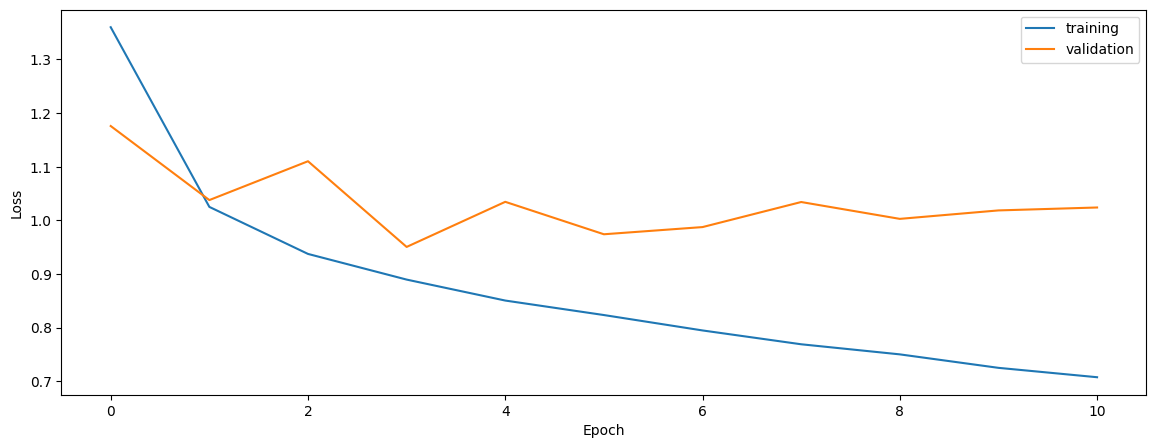

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6649154162261922
0.6323200041348656
0.6352858286072162


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.6205019393109742
0.6287785068846816
0.5722808777976528


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.6218443967856128
0.6198701727362746
0.5836649611521698


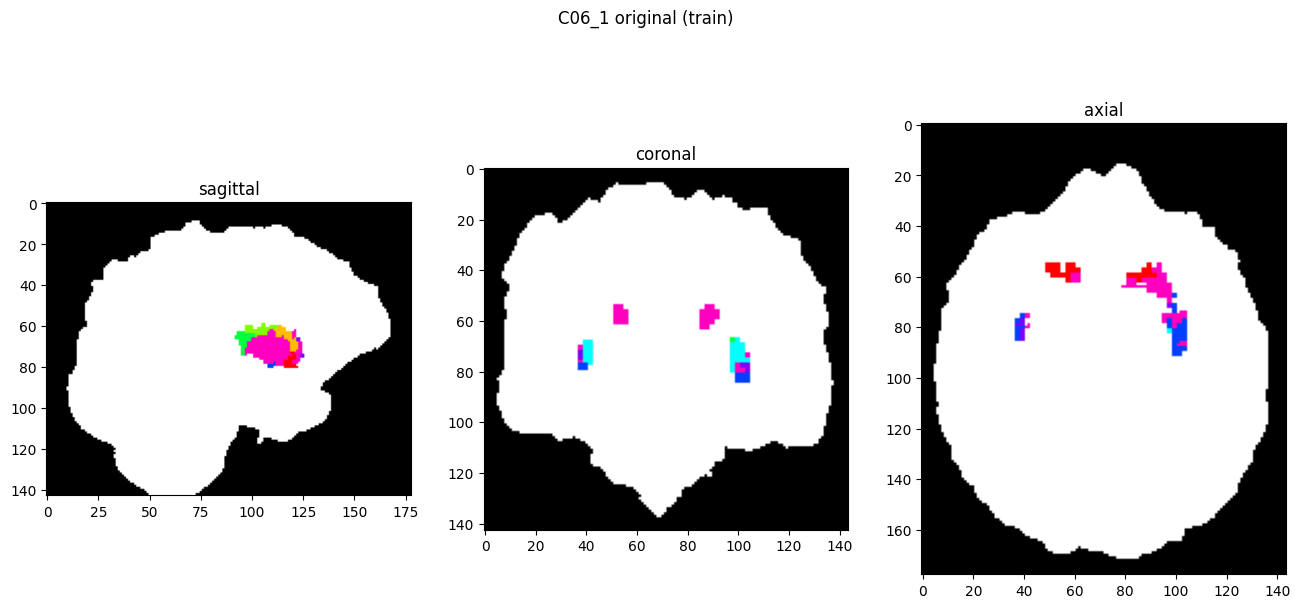

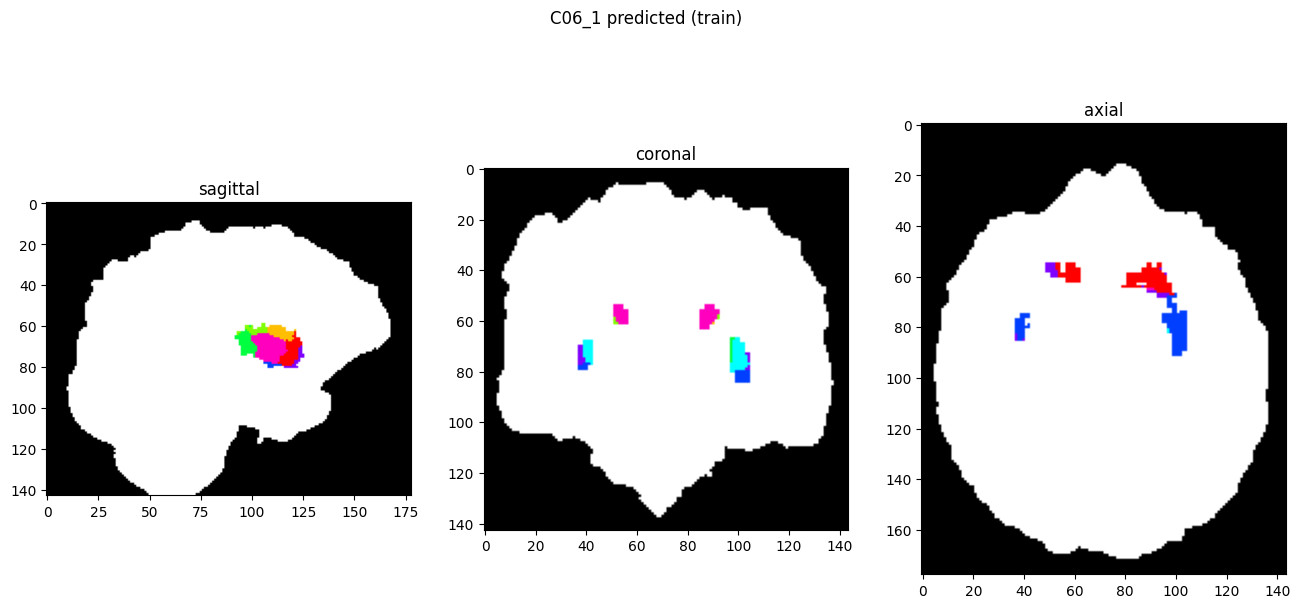

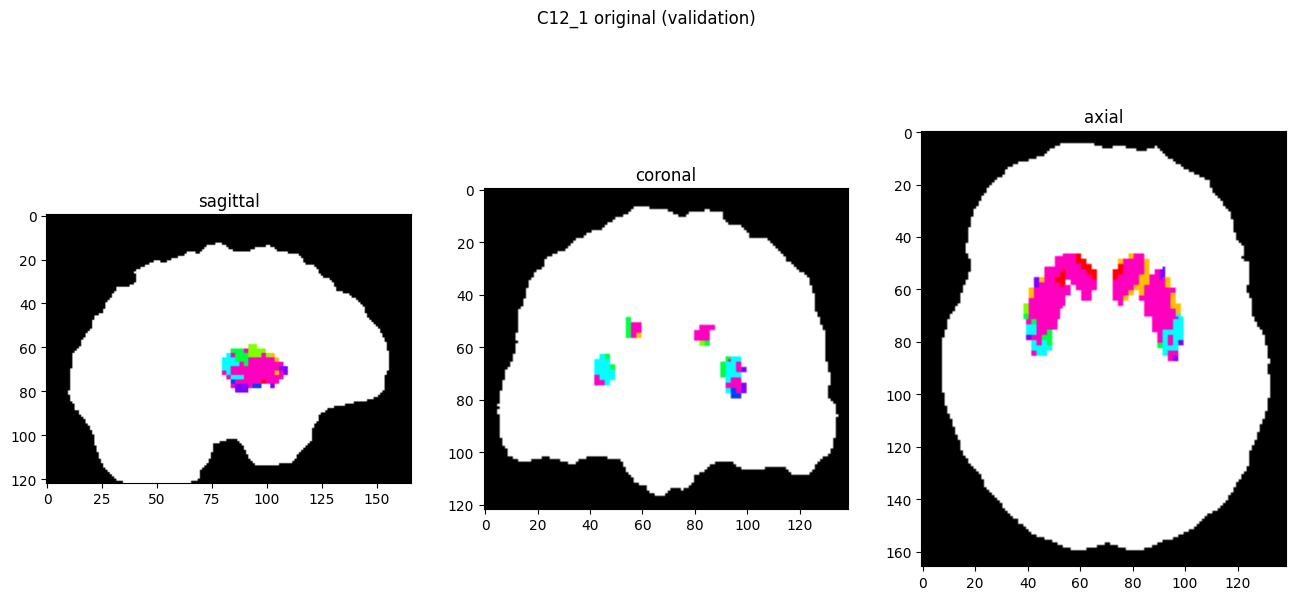

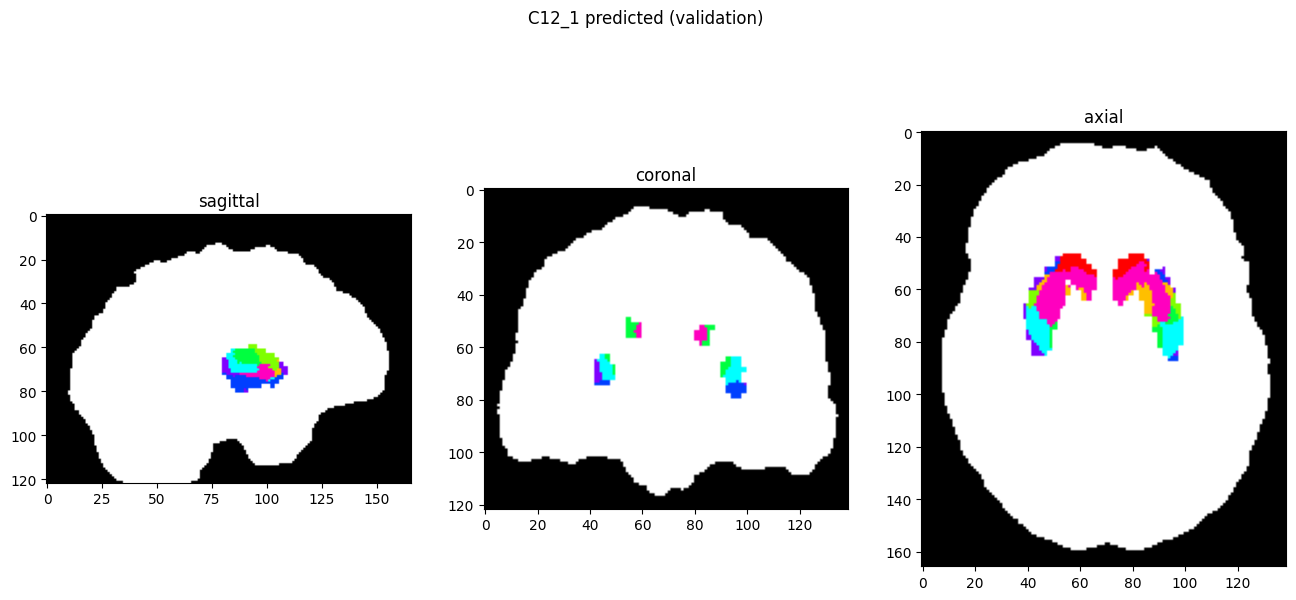

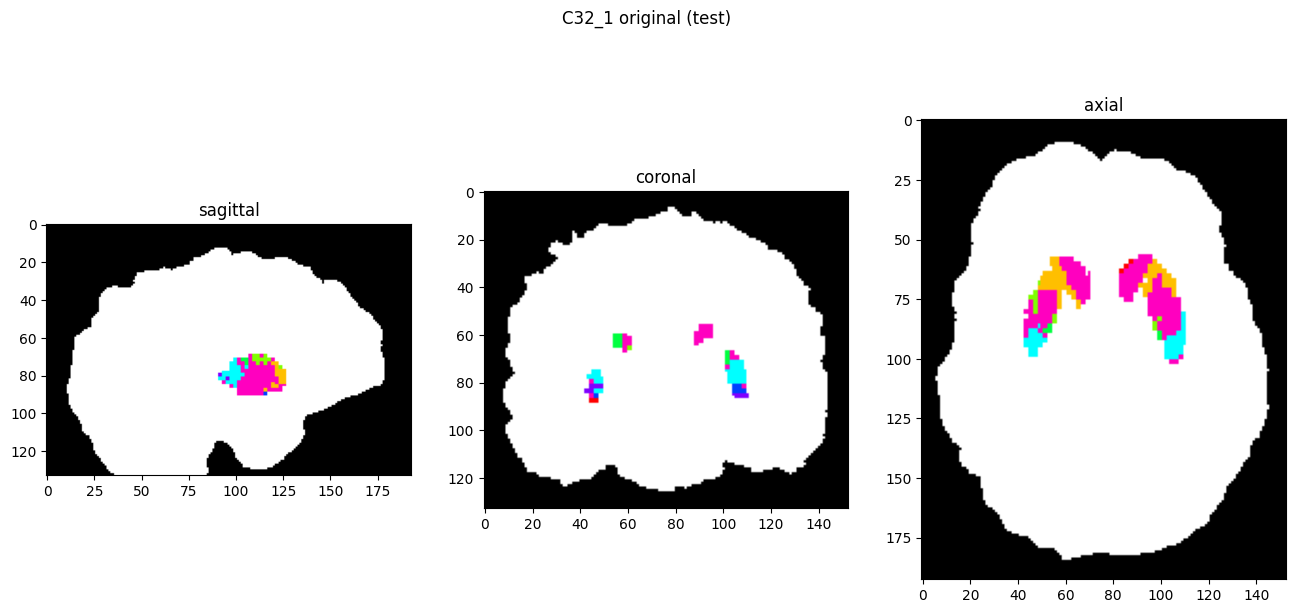

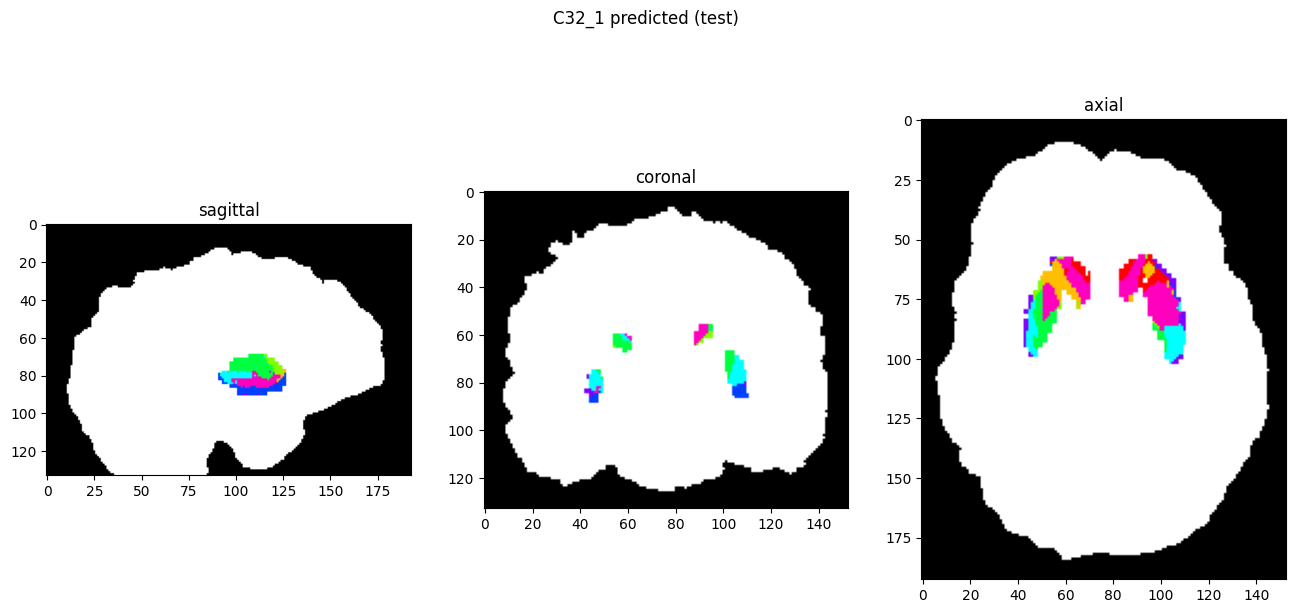

In [10]:
showResults(model, gen, threshold=0)